**Daily player selection using random forest**


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [6]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [7]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [8]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [9]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Import data from database

In [10]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [11]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

In [12]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

## Get statcast pitch-by-pitch data

In [13]:
# Get statcast 2015 data
sql_query = """
SELECT * FROM statcast_15 
WHERE statcast_15.events IS NOT NULL;
"""

df_sc_15 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [14]:
df_sc_15.shape

(184080, 91)

<IPython.core.display.Javascript object>

In [15]:
# Get statcast 2016 data
sql_query = """
SELECT * FROM statcast_16 
WHERE statcast_16.events IS NOT NULL;
"""

df_sc_16 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [16]:
df_sc_16.shape

(182719, 91)

<IPython.core.display.Javascript object>

In [17]:
# Get statcast 2017-19 data
sql_query = """
SELECT * FROM statcast 
WHERE statcast.events IS NOT NULL;
"""

df_sc_171819 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [18]:
df_sc_171819.shape

(555396, 91)

<IPython.core.display.Javascript object>

In [19]:
df_sc_all = pd.concat([df_sc_15, df_sc_16, df_sc_171819], axis=0)
df_sc_all.drop(["level_0", "index"], axis=1, inplace=True)
df_sc_all.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [20]:
df_sc_all.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,SI,2015-10-04,97.2,-1.3222,6.4094,Jeurys Familia,150029.0,544727.0,field_out,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,None,None
1,1,SI,2015-10-04,98.4,-1.2591,6.3362,Jeurys Familia,547180.0,544727.0,double,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Strategic
2,2,SI,2015-10-04,97.7,-1.2283,6.2723,Jeurys Familia,607208.0,544727.0,strikeout,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Standard
3,3,SI,2015-10-04,97.6,-1.2410,6.3449,Jeurys Familia,543685.0,544727.0,field_out,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Standard
4,4,SI,2015-10-04,97.7,-2.7596,6.1490,Blake Treinen,502517.0,595014.0,grounded_into_double_play,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Standard,Standard


<IPython.core.display.Javascript object>

In [21]:
# Encode events

# All on-base
event_list = ["hit_by_pitch", "walk", "single", "double", "triple", "home_run"]
df_sc_all["onbase_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "onbase_event"] = 1

# Walk
event_list = ["walk"]
df_sc_all["walk_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "walk_event"] = 1

# Singles
event_list = ["single"]
df_sc_all["single_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "single_event"] = 1

# 2B
event_list = ["double"]
df_sc_all["double_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "double_event"] = 1

# 3B
event_list = ["triple"]
df_sc_all["triple_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "triple_event"] = 1

# HR
event_list = ["home_run"]
df_sc_all["homerun_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "homerun_event"] = 1

# strikeout
event_list = ["strikeout"]
df_sc_all["strikeout_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "strikeout_event"] = 1

<IPython.core.display.Javascript object>

## Batter characteristics 

 <<< -------- update app and slides to account for new PA min, removed switch hitters ------- >>>>>>>

In [22]:
# 200 PA, aggregated
df_batting1519agg_200pa = batting_stats(2015, 2019, qual=200, ind=1)


<IPython.core.display.Javascript object>

In [23]:
def get_binned_counts_data_against(index_col, bin_col, df):
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = ["batters_PA_vs_" + bin_col + str(i) for i in df_counts.columns]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [24]:
def get_binned_batter_counts_data(index_col, bin_col, df):
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = ["batters_PA_as_" + bin_col + str(i) for i in df_counts.columns]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [25]:
## Filter statcast data to only be hitters with 250 PA

<IPython.core.display.Javascript object>

In [26]:
# Filter statcast data to only be hitters with 250 PA
df_batting_fromsc = pd.DataFrame()
df_batting_fromsc[
    ["batters_PA_as_L", "batters_PA_as_R"]
] = get_binned_batter_counts_data("batter", "stand", df_sc_all.iloc[:, 0:30])

df_batting_fromsc[["PA_vs_LHP", "PA_vs_RHP"]] = get_binned_counts_data_against(
    "batter", "p_throws", df_sc_all.iloc[:, 0:30]
)
df_batting_fromsc["PA"] = df_sc_all.iloc[:, 0:30].groupby("batter").count()["index"]

<IPython.core.display.Javascript object>

In [27]:
df_batting_fromsc.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA
batter,,,,,
112526.0,0.0,151.0,40.0,111.0,151
115629.0,0.0,1.0,1.0,0.0,1
116338.0,0.0,569.0,173.0,396.0,569
120074.0,1233.0,1.0,334.0,900.0,1234
121347.0,0.0,866.0,277.0,589.0,866


<IPython.core.display.Javascript object>

In [28]:
# Count number of switch hitters, at least 10% of their PA
bool_switch_hitters = (
    df_batting_fromsc["batters_PA_as_L"] > df_batting_fromsc["PA"] * 0.1
) & (df_batting_fromsc["batters_PA_as_R"] > df_batting_fromsc["PA"] * 0.1)

<IPython.core.display.Javascript object>

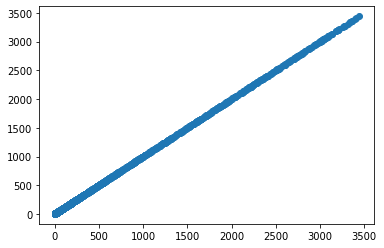

<IPython.core.display.Javascript object>

In [29]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_batting_fromsc["batters_PA_as_L"] + df_batting_fromsc["batters_PA_as_R"],
    df_batting_fromsc["PA"],
)

In [30]:
# Remove switch hitters
df_batting_fromsc = df_batting_fromsc.loc[~bool_switch_hitters, :].copy()

<IPython.core.display.Javascript object>

In [31]:
# Assign stance
df_batting_fromsc["batter_stance"] = "L"
bool_more_RH_at_bats = (
    df_batting_fromsc["batters_PA_as_R"] > df_batting_fromsc["batters_PA_as_L"]
)
df_batting_fromsc.loc[bool_more_RH_at_bats, "batter_stance"] = "R"

<IPython.core.display.Javascript object>

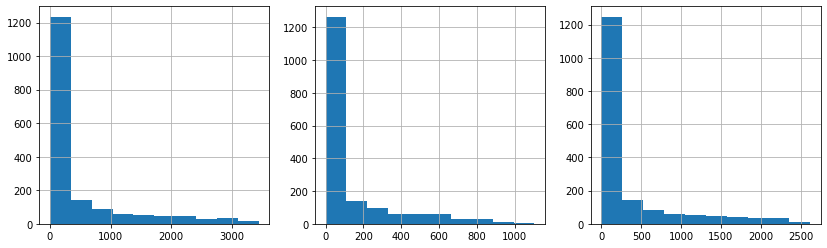

<IPython.core.display.Javascript object>

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc["PA"].hist(ax=ax1)
df_batting_fromsc["PA_vs_LHP"].hist(ax=ax2)
df_batting_fromsc["PA_vs_RHP"].hist(ax=ax3)

In [33]:
df_batting_fromsc_250pa = df_batting_fromsc.loc[
    ((df_batting_fromsc["PA_vs_LHP"] > 250) & (df_batting_fromsc["PA_vs_RHP"] > 250)), :
]

<IPython.core.display.Javascript object>

In [34]:
print(
    "No. of batters with >250 PA against LHP and RHP each: ",
    len(df_batting_fromsc_250pa),
)

No. of batters with >250 PA against LHP and RHP each:  315


<IPython.core.display.Javascript object>

In [35]:
df_batting_fromsc_250pa.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA,batter_stance
batter,,,,,,
120074.0,1233.0,1.0,334.0,900.0,1234,L
121347.0,0.0,866.0,277.0,589.0,866,R
134181.0,0.0,2127.0,592.0,1535.0,2127,R
150029.0,0.0,1274.0,280.0,994.0,1274,R
400284.0,1525.0,0.0,253.0,1272.0,1525,L


<IPython.core.display.Javascript object>

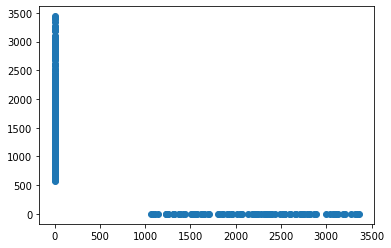

<IPython.core.display.Javascript object>

In [36]:
# Verification of switch hitter removal
plt.scatter(
    df_batting_fromsc_250pa["batters_PA_as_L"],
    df_batting_fromsc_250pa["batters_PA_as_R"],
)

In [37]:
df_batting_fromsc_250pa.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA,batter_stance
batter,,,,,,
120074.0,1233.0,1.0,334.0,900.0,1234,L
121347.0,0.0,866.0,277.0,589.0,866,R
134181.0,0.0,2127.0,592.0,1535.0,2127,R
150029.0,0.0,1274.0,280.0,994.0,1274,R
400284.0,1525.0,0.0,253.0,1272.0,1525,L


<IPython.core.display.Javascript object>

In [38]:
# Get proportion of counts for each event (on-base, walk, single, etc...)

<IPython.core.display.Javascript object>

In [39]:
def get_prop_event_data(index_col, bin_col, event, df):
    #     df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    #     df_counts.columns = ["PA_vs_" + bin_col + str(i) for i in df_counts.columns]
    df_event_mean = (df.groupby([index_col, bin_col]).mean()[event]).unstack()
    df_event_mean.columns = [
        "prop_" + event + "_" + bin_col + "_" + str(i) for i in df_event_mean.columns
    ]
    df_event_mean["prop_" + event + "_overall"] = df.groupby([index_col]).mean()[event]
    # df_binned = pd.merge(df_counts, df_event_mean, left_index=True, right_index=True)
    return df_event_mean

<IPython.core.display.Javascript object>

In [40]:
# del df_batting_fromsc_250pa_prop_events

<IPython.core.display.Javascript object>

In [41]:
df_temp = get_prop_event_data("batter", "p_throws", "onbase_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa, df_temp, left_index=True, right_index=True
)

# Note change in left table to merge - all other events will be added in
df_temp = get_prop_event_data("batter", "p_throws", "walk_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "single_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "double_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "triple_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "homerun_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "strikeout_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [42]:
df_batting_fromsc_250pa_prop_events.shape

(315, 27)

<IPython.core.display.Javascript object>

In [43]:
df_batting_fromsc_250pa_prop_events.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA,batter_stance,prop_onbase_event_p_throws_L,prop_onbase_event_p_throws_R,prop_onbase_event_overall,prop_walk_event_p_throws_L,...,prop_double_event_overall,prop_triple_event_p_throws_L,prop_triple_event_p_throws_R,prop_triple_event_overall,prop_homerun_event_p_throws_L,prop_homerun_event_p_throws_R,prop_homerun_event_overall,prop_strikeout_event_p_throws_L,prop_strikeout_event_p_throws_R,prop_strikeout_event_overall
batter,,,,,,,,,,,,,,,,,,,,,
120074.0,1233.0,1.0,334.0,900.0,1234,L,0.320359,0.368889,0.355754,0.080838,...,0.068882,0.000000,0.001111,0.000810,0.038922,0.068889,0.060778,0.176647,0.131111,0.143436
121347.0,0.0,866.0,277.0,589.0,866,R,0.335740,0.310696,0.318707,0.115523,...,0.033487,0.003610,0.000000,0.001155,0.046931,0.049236,0.048499,0.252708,0.241087,0.244804
134181.0,0.0,2127.0,592.0,1535.0,2127,R,0.373311,0.330293,0.342266,0.094595,...,0.050776,0.006757,0.001954,0.003291,0.043919,0.036482,0.038552,0.130068,0.130293,0.130230
150029.0,0.0,1274.0,280.0,994.0,1274,R,0.357143,0.310865,0.321036,0.114286,...,0.042386,0.000000,0.002012,0.001570,0.057143,0.027163,0.033752,0.210714,0.231388,0.226845
400284.0,1525.0,0.0,253.0,1272.0,1525,L,0.252964,0.315252,0.304918,0.071146,...,0.050492,0.003953,0.007075,0.006557,0.015810,0.021226,0.020328,0.225296,0.165881,0.175738


<IPython.core.display.Javascript object>

### Represent handedness of opposing pitcher explicitly

In [44]:
same_hand_colnames = [
    "prop_onbase_event_p_throws_same",
    "prop_walk_event_p_throws_same",
    "prop_single_event_p_throws_same",
    "prop_double_event_p_throws_same",
    "prop_triple_event_p_throws_same",
    "prop_homerun_event_p_throws_same",
    "prop_strikeout_event_p_throws_same",
]

diff_hand_colnames = [
    "prop_onbase_event_p_throws_diff",
    "prop_walk_event_p_throws_diff",
    "prop_single_event_p_throws_diff",
    "prop_double_event_p_throws_diff",
    "prop_triple_event_p_throws_diff",
    "prop_homerun_event_p_throws_diff",
    "prop_strikeout_event_p_throws_diff",
]

for colname2start in same_hand_colnames + diff_hand_colnames:
    df_batting_fromsc_250pa_prop_events[colname2start] = None

<IPython.core.display.Javascript object>

In [45]:
# Add same different columns of proportions for each batter
for b_index in df_batting_fromsc_250pa_prop_events.index.tolist():
    # print(b_index)
    same_hand = df_batting_fromsc_250pa_prop_events.loc[b_index, "batter_stance"][0]
    diff_hand = list(set(["L", "R"]) - set(same_hand))[0]

    # Same / diff handedness
    same_hand_col = df_batting_fromsc_250pa_prop_events.columns.str.contains(
        "p_throws_" + same_hand
    )
    same_hand_prop_info = df_batting_fromsc_250pa_prop_events.loc[
        b_index, same_hand_col
    ]
    same_hand_prop_info.index = same_hand_prop_info.index.str.replace(same_hand, "same")

    diff_hand_col = df_batting_fromsc_250pa_prop_events.columns.str.contains(
        "p_throws_" + diff_hand
    )
    diff_hand_prop_info = df_batting_fromsc_250pa_prop_events.loc[
        b_index, diff_hand_col
    ]
    diff_hand_prop_info.index = diff_hand_prop_info.index.str.replace(diff_hand, "diff")

    # Add to dataframe
    df_batting_fromsc_250pa_prop_events.loc[
        b_index, same_hand_prop_info.index.tolist()
    ] = same_hand_prop_info
    df_batting_fromsc_250pa_prop_events.loc[
        b_index, diff_hand_prop_info.index.tolist()
    ] = diff_hand_prop_info

    # print("      ", same_hand, diff_hand)

<IPython.core.display.Javascript object>

In [46]:
df_batting_fromsc_250pa_prop_events.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA,batter_stance,prop_onbase_event_p_throws_L,prop_onbase_event_p_throws_R,prop_onbase_event_overall,prop_walk_event_p_throws_L,...,prop_triple_event_p_throws_same,prop_homerun_event_p_throws_same,prop_strikeout_event_p_throws_same,prop_onbase_event_p_throws_diff,prop_walk_event_p_throws_diff,prop_single_event_p_throws_diff,prop_double_event_p_throws_diff,prop_triple_event_p_throws_diff,prop_homerun_event_p_throws_diff,prop_strikeout_event_p_throws_diff
batter,,,,,,,,,,,,,,,,,,,,,
120074.0,1233.0,1.0,334.0,900.0,1234,L,0.320359,0.368889,0.355754,0.080838,...,0,0.0389222,0.176647,0.368889,0.108889,0.112222,0.0755556,0.00111111,0.0688889,0.131111
121347.0,0.0,866.0,277.0,589.0,866,R,0.335740,0.310696,0.318707,0.115523,...,0,0.049236,0.241087,0.33574,0.115523,0.104693,0.0505415,0.00361011,0.0469314,0.252708
134181.0,0.0,2127.0,592.0,1535.0,2127,R,0.373311,0.330293,0.342266,0.094595,...,0.0019544,0.0364821,0.130293,0.373311,0.0945946,0.173986,0.0489865,0.00675676,0.0439189,0.130068
150029.0,0.0,1274.0,280.0,994.0,1274,R,0.357143,0.310865,0.321036,0.114286,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
400284.0,1525.0,0.0,253.0,1272.0,1525,L,0.252964,0.315252,0.304918,0.071146,...,0.00395257,0.0158103,0.225296,0.315252,0.0754717,0.138365,0.0518868,0.00707547,0.0212264,0.165881


<IPython.core.display.Javascript object>

## Pitching characteristics


< ------ use only data with minimum number of plate appearances but allow all batters/pitchers and just put warning if they're less than 250/500 ------> 

In [47]:
def get_binned_pitcher_counts_data(index_col, bin_col, df):
    """
    Represent handedness of the pitcher by counting at-bats with that hand
    """
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = [
        "pitchers_PA_as_" + bin_col + str(i) for i in df_counts.columns
    ]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [48]:
# Filter statcast data to only be pitchers with 500 PA for each hand
df_pitching_fromsc = pd.DataFrame()

df_pitching_fromsc[
    ["pitchers_PA_as_L", "pitchers_PA_as_R"]
] = get_binned_pitcher_counts_data("pitcher", "p_throws", df_sc_all.iloc[:, 0:30])

df_pitching_fromsc[
    ["pitcher_PA_vs_LHB", "pitcher_PA_vs_RHB"]
] = get_binned_counts_data_against("pitcher", "stand", df_sc_all.iloc[:, 0:30])

df_pitching_fromsc["pitcher_PA"] = (
    df_sc_all.iloc[:, 0:30].groupby("pitcher").count()["index"]
)

<IPython.core.display.Javascript object>

In [49]:
# Assign throwing hand
df_pitching_fromsc['pitchers_throwing_hand'] = 'L'
bool_more_RH_p_throws = (
    df_pitching_fromsc['pitchers_PA_as_R'] > df_pitching_fromsc['pitchers_PA_as_L']
)
df_pitching_fromsc.loc[bool_more_RH_p_throws, 'pitchers_throwing_hand'] = 'R'


<IPython.core.display.Javascript object>

In [50]:
df_pitching_fromsc.head()

,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand
pitcher,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R
115629.0,0.0,162.0,81.0,81.0,162,R
136600.0,35.0,0.0,12.0,23.0,35,L
150116.0,162.0,0.0,30.0,132.0,162,L
150274.0,0.0,29.0,10.0,19.0,29,R


<IPython.core.display.Javascript object>

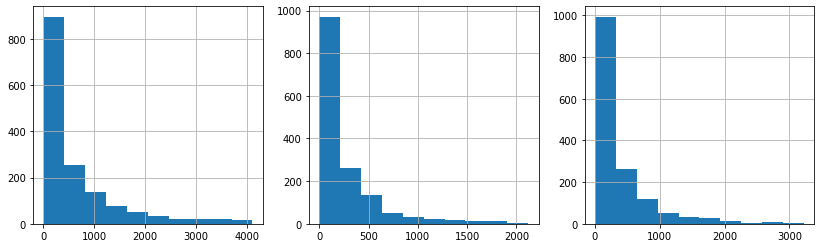

<IPython.core.display.Javascript object>

In [51]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc["pitcher_PA"].hist(ax=ax1)
df_pitching_fromsc["pitcher_PA_vs_LHB"].hist(ax=ax2)
df_pitching_fromsc["pitcher_PA_vs_RHB"].hist(ax=ax3)

In [52]:
df_pitching_fromsc_500pa = df_pitching_fromsc.loc[
    (
        (df_pitching_fromsc["pitcher_PA_vs_LHB"] > 500)
        & (df_pitching_fromsc["pitcher_PA_vs_RHB"] > 500)
    ),
    :,
]

<IPython.core.display.Javascript object>

In [53]:
print(
    "No. of pitchers with >500 PA against LHB and RHB each: ",
    len(df_pitching_fromsc_500pa),
)

No. of pitchers with >500 PA against LHB and RHB each:  230


<IPython.core.display.Javascript object>

In [54]:
# del df_pitching_fromsc_500pa_prop_events

<IPython.core.display.Javascript object>

In [55]:
df_temp = get_prop_event_data("pitcher", "stand", "onbase_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa, df_temp, left_index=True, right_index=True
)

# Note change in left table to merge - all other events will be added in
df_temp = get_prop_event_data("pitcher", "stand", "walk_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "single_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "double_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "triple_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "homerun_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "strikeout_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [56]:
print("pitching df shape: ", df_pitching_fromsc_500pa_prop_events.shape)
df_pitching_fromsc_500pa_prop_events.head()

pitching df shape:  (230, 27)


,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand,prop_onbase_event_stand_L,prop_onbase_event_stand_R,prop_onbase_event_overall,prop_walk_event_stand_L,...,prop_double_event_overall,prop_triple_event_stand_L,prop_triple_event_stand_R,prop_triple_event_overall,prop_homerun_event_stand_L,prop_homerun_event_stand_R,prop_homerun_event_overall,prop_strikeout_event_stand_L,prop_strikeout_event_stand_R,prop_strikeout_event_overall
pitcher,,,,,,,,,,,,,,,,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R,0.315752,0.308224,0.311955,0.047117,...,0.056466,0.008439,0.006911,0.007668,0.034459,0.040774,0.037644,0.143460,0.154112,0.148832
282332.0,3255.0,0.0,635.0,2620.0,3255,L,0.294488,0.327481,0.321045,0.085039,...,0.036866,0.003150,0.003053,0.003072,0.029921,0.037405,0.035945,0.251969,0.188168,0.200614
285079.0,0.0,2430.0,1096.0,1334.0,2430,R,0.304745,0.327586,0.317284,0.082117,...,0.050206,0.006387,0.008246,0.007407,0.031934,0.032984,0.032510,0.142336,0.173913,0.159671
407793.0,0.0,2375.0,1089.0,1286.0,2375,R,0.326905,0.265163,0.293474,0.084481,...,0.036632,0.003673,0.001555,0.002526,0.034894,0.032659,0.033684,0.166208,0.250389,0.211789
407845.0,0.0,1282.0,633.0,649.0,1282,R,0.336493,0.322034,0.329173,0.126382,...,0.033541,0.001580,0.001541,0.001560,0.023697,0.021572,0.022621,0.271722,0.218798,0.244930


<IPython.core.display.Javascript object>

### Represent handedness of opposing batter explicitly

In [57]:
same_bhand_colnames = [
    "prop_onbase_event_stand_same",
    "prop_walk_event_stand_same",
    "prop_single_event_stand_same",
    "prop_double_event_stand_same",
    "prop_triple_event_stand_same",
    "prop_homerun_event_stand_same",
    "prop_strikeout_event_stand_same",
]

diff_bhand_colnames = [
    "prop_onbase_event_stand_diff",
    "prop_walk_event_stand_diff",
    "prop_single_event_stand_diff",
    "prop_double_event_stand_diff",
    "prop_triple_event_stand_diff",
    "prop_homerun_event_stand_diff",
    "prop_strikeout_event_stand_diff",
]

for colname2start in same_bhand_colnames + diff_bhand_colnames:
    df_pitching_fromsc_500pa_prop_events[colname2start] = None

<IPython.core.display.Javascript object>

In [58]:
df_pitching_fromsc_500pa_prop_events.head()

,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand,prop_onbase_event_stand_L,prop_onbase_event_stand_R,prop_onbase_event_overall,prop_walk_event_stand_L,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
pitcher,,,,,,,,,,,,,,,,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R,0.315752,0.308224,0.311955,0.047117,...,None,None,None,None,None,None,None,None,None,None
282332.0,3255.0,0.0,635.0,2620.0,3255,L,0.294488,0.327481,0.321045,0.085039,...,None,None,None,None,None,None,None,None,None,None
285079.0,0.0,2430.0,1096.0,1334.0,2430,R,0.304745,0.327586,0.317284,0.082117,...,None,None,None,None,None,None,None,None,None,None
407793.0,0.0,2375.0,1089.0,1286.0,2375,R,0.326905,0.265163,0.293474,0.084481,...,None,None,None,None,None,None,None,None,None,None
407845.0,0.0,1282.0,633.0,649.0,1282,R,0.336493,0.322034,0.329173,0.126382,...,None,None,None,None,None,None,None,None,None,None


<IPython.core.display.Javascript object>

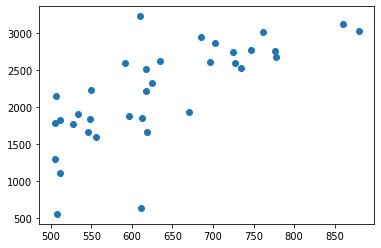

<IPython.core.display.Javascript object>

In [59]:
# LHP still throw more to RHBs
df_temp = df_pitching_fromsc_500pa_prop_events[
    df_pitching_fromsc_500pa_prop_events["pitchers_throwing_hand"] == "L"
].copy()

plt.scatter(df_temp["pitcher_PA_vs_LHB"], df_temp["pitcher_PA_vs_RHB"])

In [60]:
# Add same different columns of proportions for each batter
for p_index in df_pitching_fromsc_500pa_prop_events.index.tolist():
    # print(p_index)
    same_hand = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, "pitchers_throwing_hand"
    ][0]
    diff_hand = list(set(["L", "R"]) - set(same_hand))[0]

    # Same / diff handedness
    same_hand_col = df_pitching_fromsc_500pa_prop_events.columns.str.contains(
        "stand_" + same_hand
    )
    same_hand_prop_info = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, same_hand_col
    ]
    same_hand_prop_info.index = same_hand_prop_info.index.str.replace(same_hand, "same")

    diff_hand_col = df_pitching_fromsc_500pa_prop_events.columns.str.contains(
        "stand_" + diff_hand
    )
    diff_hand_prop_info = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, diff_hand_col
    ]
    diff_hand_prop_info.index = diff_hand_prop_info.index.str.replace(diff_hand, "diff")

    # Add to dataframe
    df_pitching_fromsc_500pa_prop_events.loc[
        p_index, same_hand_prop_info.index.tolist()
    ] = same_hand_prop_info
    df_pitching_fromsc_500pa_prop_events.loc[
        p_index, diff_hand_prop_info.index.tolist()
    ] = diff_hand_prop_info

    # print("      ", same_hand, diff_hand)

<IPython.core.display.Javascript object>

In [61]:
df_pitching_fromsc_500pa_prop_events.head()

,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand,prop_onbase_event_stand_L,prop_onbase_event_stand_R,prop_onbase_event_overall,prop_walk_event_stand_L,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
pitcher,,,,,,,,,,,,,,,,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R,0.315752,0.308224,0.311955,0.047117,...,0.00691085,0.040774,0.154112,0.315752,0.0471167,0.164557,0.0576653,0.00843882,0.0344585,0.14346
282332.0,3255.0,0.0,635.0,2620.0,3255,L,0.294488,0.327481,0.321045,0.085039,...,0.00314961,0.0299213,0.251969,0.327481,0.0748092,0.166031,0.0408397,0.00305344,0.0374046,0.188168
285079.0,0.0,2430.0,1096.0,1334.0,2430,R,0.304745,0.327586,0.317284,0.082117,...,0.00824588,0.0329835,0.173913,0.304745,0.0821168,0.12865,0.0474453,0.00638686,0.0319343,0.142336
407793.0,0.0,2375.0,1089.0,1286.0,2375,R,0.326905,0.265163,0.293474,0.084481,...,0.00155521,0.0326594,0.250389,0.326905,0.0844812,0.155188,0.0394858,0.00367309,0.0348944,0.166208
407845.0,0.0,1282.0,633.0,649.0,1282,R,0.336493,0.322034,0.329173,0.126382,...,0.00154083,0.0215716,0.218798,0.336493,0.126382,0.14218,0.0315956,0.00157978,0.0236967,0.271722


<IPython.core.display.Javascript object>

# Exploratory data 

### Plots showing distribution of batter quality

onbase, single, double, 
triple, homerun, strikeout

In [62]:
df_batting_fromsc_250pa_prop_events.head()

,batters_PA_as_L,batters_PA_as_R,PA_vs_LHP,PA_vs_RHP,PA,batter_stance,prop_onbase_event_p_throws_L,prop_onbase_event_p_throws_R,prop_onbase_event_overall,prop_walk_event_p_throws_L,...,prop_triple_event_p_throws_same,prop_homerun_event_p_throws_same,prop_strikeout_event_p_throws_same,prop_onbase_event_p_throws_diff,prop_walk_event_p_throws_diff,prop_single_event_p_throws_diff,prop_double_event_p_throws_diff,prop_triple_event_p_throws_diff,prop_homerun_event_p_throws_diff,prop_strikeout_event_p_throws_diff
batter,,,,,,,,,,,,,,,,,,,,,
120074.0,1233.0,1.0,334.0,900.0,1234,L,0.320359,0.368889,0.355754,0.080838,...,0,0.0389222,0.176647,0.368889,0.108889,0.112222,0.0755556,0.00111111,0.0688889,0.131111
121347.0,0.0,866.0,277.0,589.0,866,R,0.335740,0.310696,0.318707,0.115523,...,0,0.049236,0.241087,0.33574,0.115523,0.104693,0.0505415,0.00361011,0.0469314,0.252708
134181.0,0.0,2127.0,592.0,1535.0,2127,R,0.373311,0.330293,0.342266,0.094595,...,0.0019544,0.0364821,0.130293,0.373311,0.0945946,0.173986,0.0489865,0.00675676,0.0439189,0.130068
150029.0,0.0,1274.0,280.0,994.0,1274,R,0.357143,0.310865,0.321036,0.114286,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
400284.0,1525.0,0.0,253.0,1272.0,1525,L,0.252964,0.315252,0.304918,0.071146,...,0.00395257,0.0158103,0.225296,0.315252,0.0754717,0.138365,0.0518868,0.00707547,0.0212264,0.165881


<IPython.core.display.Javascript object>

In [63]:
print("No. of batters of each hand")
df_batting_fromsc_250pa_prop_events.groupby("batter_stance").count().iloc[:, 0]

No. of batters of each hand


batter_stance
L     93
R    222
Name: batters_PA_as_L, dtype: int64

<IPython.core.display.Javascript object>

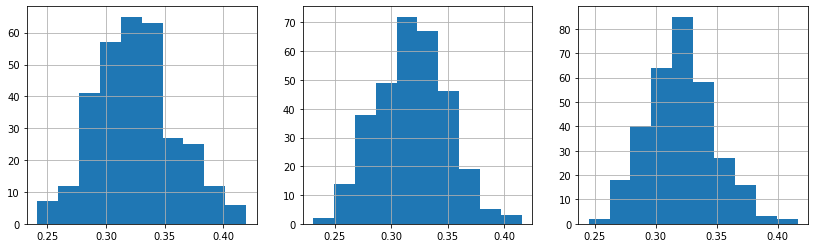

<IPython.core.display.Javascript object>

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_onbase_event_overall"].hist(ax=ax3)

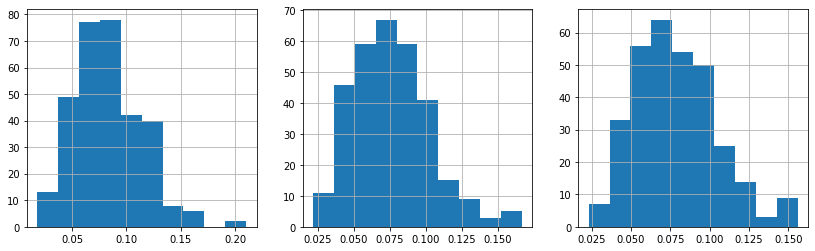

<IPython.core.display.Javascript object>

In [65]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_walk_event_overall"].hist(ax=ax3)

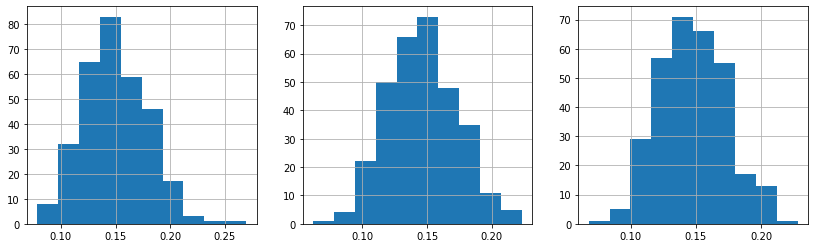

<IPython.core.display.Javascript object>

In [66]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_single_event_overall"].hist(ax=ax3)

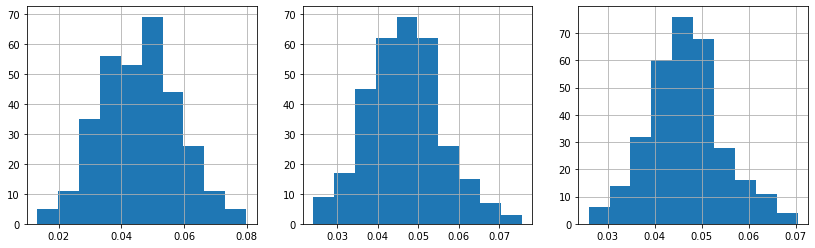

<IPython.core.display.Javascript object>

In [67]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_double_event_overall"].hist(ax=ax3)

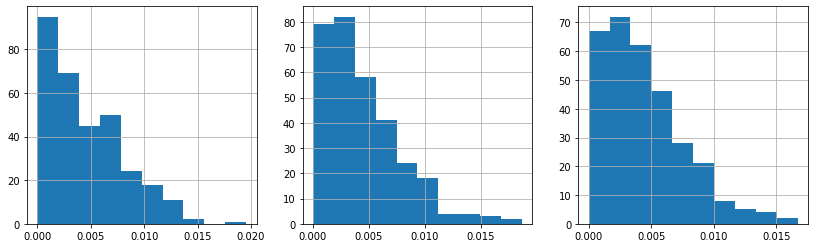

<IPython.core.display.Javascript object>

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_triple_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_triple_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_triple_event_overall"].hist(ax=ax3)

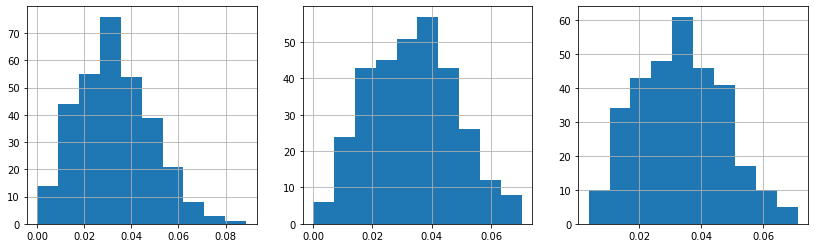

<IPython.core.display.Javascript object>

In [69]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_homerun_event_overall"].hist(ax=ax3)

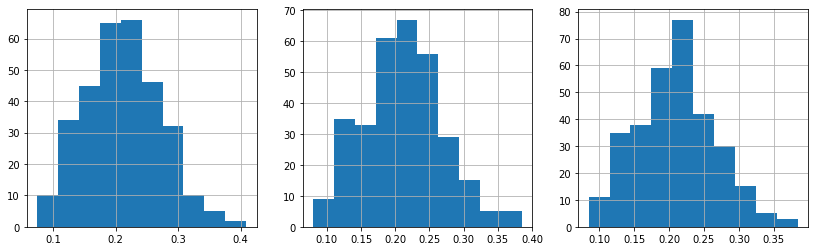

<IPython.core.display.Javascript object>

In [70]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_overall"].hist(ax=ax3)

### Plots showing distribution of pitcher quality

onbase, single, double, 
triple, homerun, strikeout

In [71]:
df_pitching_fromsc_500pa_prop_events.head()

,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand,prop_onbase_event_stand_L,prop_onbase_event_stand_R,prop_onbase_event_overall,prop_walk_event_stand_L,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
pitcher,,,,,,,,,,,,,,,,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R,0.315752,0.308224,0.311955,0.047117,...,0.00691085,0.040774,0.154112,0.315752,0.0471167,0.164557,0.0576653,0.00843882,0.0344585,0.14346
282332.0,3255.0,0.0,635.0,2620.0,3255,L,0.294488,0.327481,0.321045,0.085039,...,0.00314961,0.0299213,0.251969,0.327481,0.0748092,0.166031,0.0408397,0.00305344,0.0374046,0.188168
285079.0,0.0,2430.0,1096.0,1334.0,2430,R,0.304745,0.327586,0.317284,0.082117,...,0.00824588,0.0329835,0.173913,0.304745,0.0821168,0.12865,0.0474453,0.00638686,0.0319343,0.142336
407793.0,0.0,2375.0,1089.0,1286.0,2375,R,0.326905,0.265163,0.293474,0.084481,...,0.00155521,0.0326594,0.250389,0.326905,0.0844812,0.155188,0.0394858,0.00367309,0.0348944,0.166208
407845.0,0.0,1282.0,633.0,649.0,1282,R,0.336493,0.322034,0.329173,0.126382,...,0.00154083,0.0215716,0.218798,0.336493,0.126382,0.14218,0.0315956,0.00157978,0.0236967,0.271722


<IPython.core.display.Javascript object>

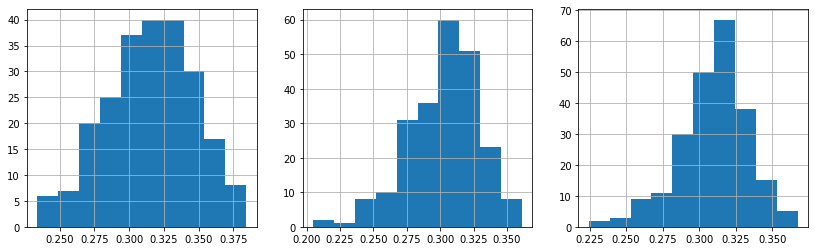

<IPython.core.display.Javascript object>

In [72]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_overall"].hist(ax=ax3)

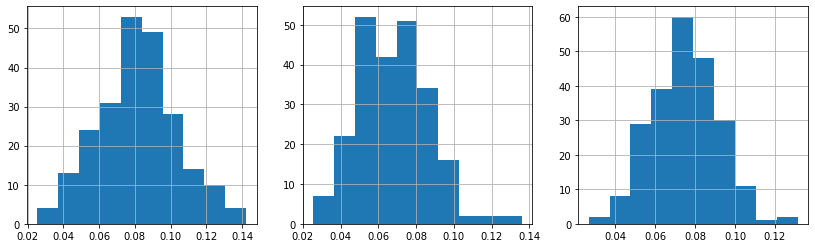

<IPython.core.display.Javascript object>

In [73]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_walk_event_overall"].hist(ax=ax3)

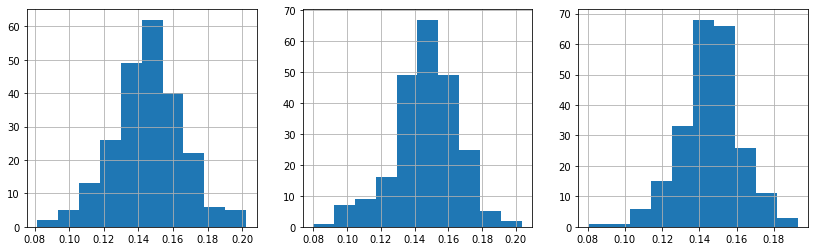

<IPython.core.display.Javascript object>

In [74]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_single_event_overall"].hist(ax=ax3)

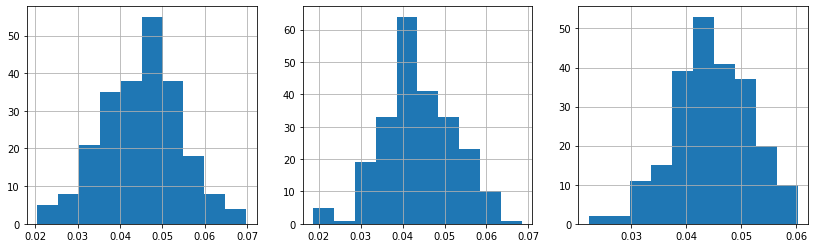

<IPython.core.display.Javascript object>

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_double_event_overall"].hist(ax=ax3)

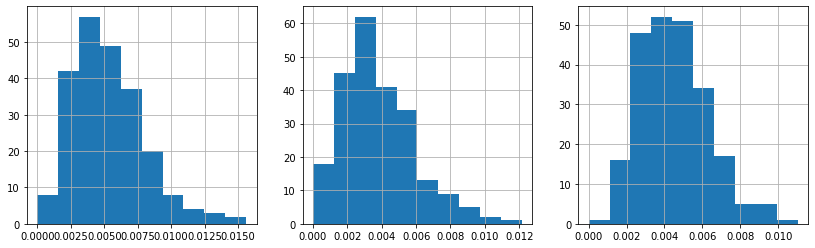

<IPython.core.display.Javascript object>

In [76]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_triple_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_triple_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_triple_event_overall"].hist(ax=ax3)

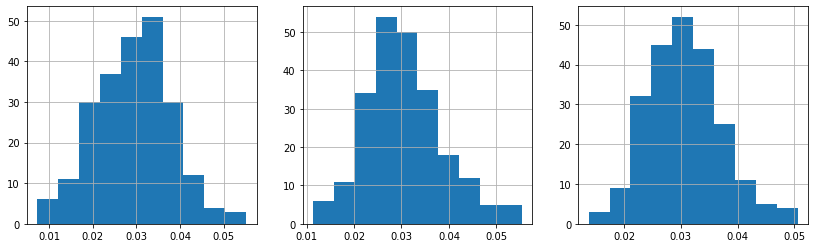

<IPython.core.display.Javascript object>

In [77]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_overall"].hist(ax=ax3)

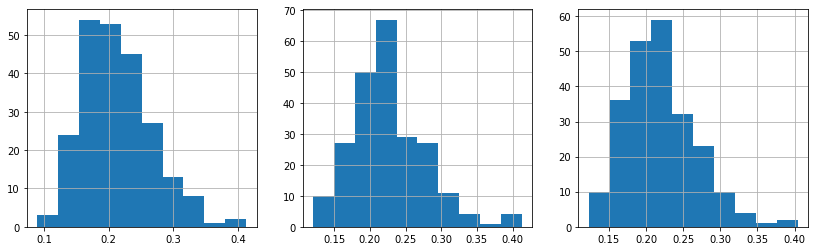

<IPython.core.display.Javascript object>

In [78]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_overall"].hist(ax=ax3)

### Plots showing some handedness differences

In [79]:
# from stack overflow
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, "--")

<IPython.core.display.Javascript object>

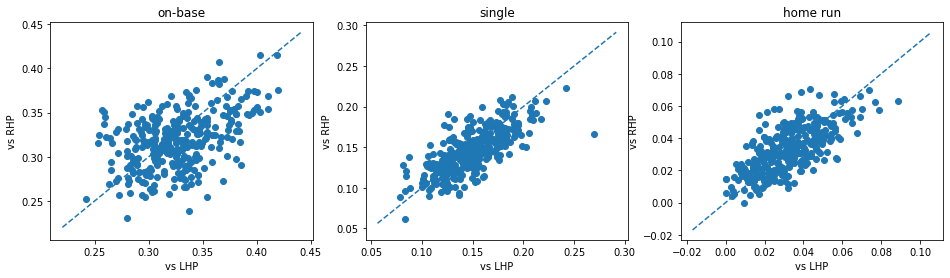

<IPython.core.display.Javascript object>

In [80]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.scatter(
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_R"],
)
ax1.set_title("on-base")
ax1.set_xlabel("vs LHP")
ax1.set_ylabel("vs RHP")
abline(1, 0, ax1)

ax2.scatter(
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_R"],
)
ax2.set_title("single")
ax2.set_xlabel("vs LHP")
ax2.set_ylabel("vs RHP")
abline(1, 0, ax2)

ax3.scatter(
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_R"],
)
ax3.set_title("home run")
ax3.set_xlabel("vs LHP")
ax3.set_ylabel("vs RHP")
abline(1, 0, ax3)

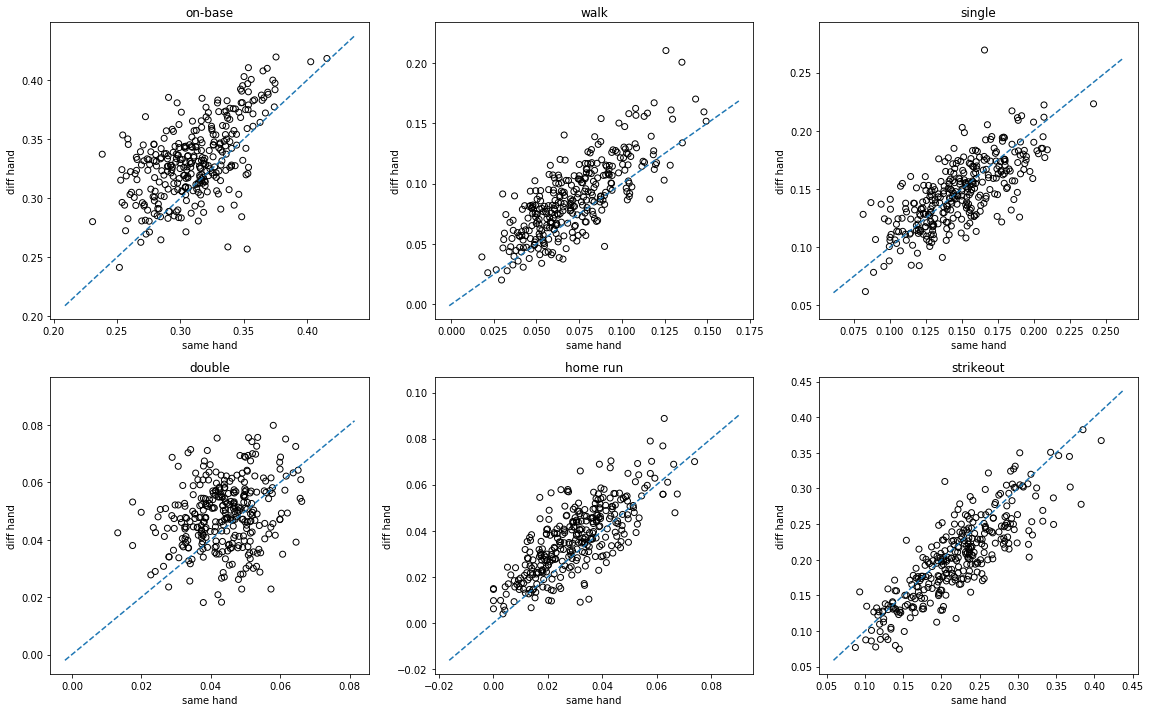

<IPython.core.display.Javascript object>

In [233]:
# Batters same vs. different handedness

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))

ax1.scatter(
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("on-base")
ax1.set_xlabel("same hand")
ax1.set_ylabel("diff hand")
abline(1, 0, ax1)

ax2.scatter(
    df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("walk")
ax2.set_xlabel("same hand")
ax2.set_ylabel("diff hand")
abline(1, 0, ax2)

ax3.scatter(
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax3.set_title("single")
ax3.set_xlabel("same hand")
ax3.set_ylabel("diff hand")
abline(1, 0, ax3)

ax4.scatter(
    df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax4.set_title("double")
ax4.set_xlabel("same hand")
ax4.set_ylabel("diff hand")
abline(1, 0, ax4)

ax5.scatter(
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax5.set_title("home run")
ax5.set_xlabel("same hand")
ax5.set_ylabel("diff hand")
abline(1, 0, ax5)

ax6.scatter(
    df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax6.set_title("strikeout")
ax6.set_xlabel("same hand")
ax6.set_ylabel("diff hand")
abline(1, 0, ax6)

plt.tight_layout()

In [82]:
df_pitching_fromsc_500pa_prop_events.head()

,pitchers_PA_as_L,pitchers_PA_as_R,pitcher_PA_vs_LHB,pitcher_PA_vs_RHB,pitcher_PA,pitchers_throwing_hand,prop_onbase_event_stand_L,prop_onbase_event_stand_R,prop_onbase_event_overall,prop_walk_event_stand_L,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
pitcher,,,,,,,,,,,,,,,,,,,,,
112526.0,0.0,2869.0,1422.0,1447.0,2869,R,0.315752,0.308224,0.311955,0.047117,...,0.00691085,0.040774,0.154112,0.315752,0.0471167,0.164557,0.0576653,0.00843882,0.0344585,0.14346
282332.0,3255.0,0.0,635.0,2620.0,3255,L,0.294488,0.327481,0.321045,0.085039,...,0.00314961,0.0299213,0.251969,0.327481,0.0748092,0.166031,0.0408397,0.00305344,0.0374046,0.188168
285079.0,0.0,2430.0,1096.0,1334.0,2430,R,0.304745,0.327586,0.317284,0.082117,...,0.00824588,0.0329835,0.173913,0.304745,0.0821168,0.12865,0.0474453,0.00638686,0.0319343,0.142336
407793.0,0.0,2375.0,1089.0,1286.0,2375,R,0.326905,0.265163,0.293474,0.084481,...,0.00155521,0.0326594,0.250389,0.326905,0.0844812,0.155188,0.0394858,0.00367309,0.0348944,0.166208
407845.0,0.0,1282.0,633.0,649.0,1282,R,0.336493,0.322034,0.329173,0.126382,...,0.00154083,0.0215716,0.218798,0.336493,0.126382,0.14218,0.0315956,0.00157978,0.0236967,0.271722


<IPython.core.display.Javascript object>

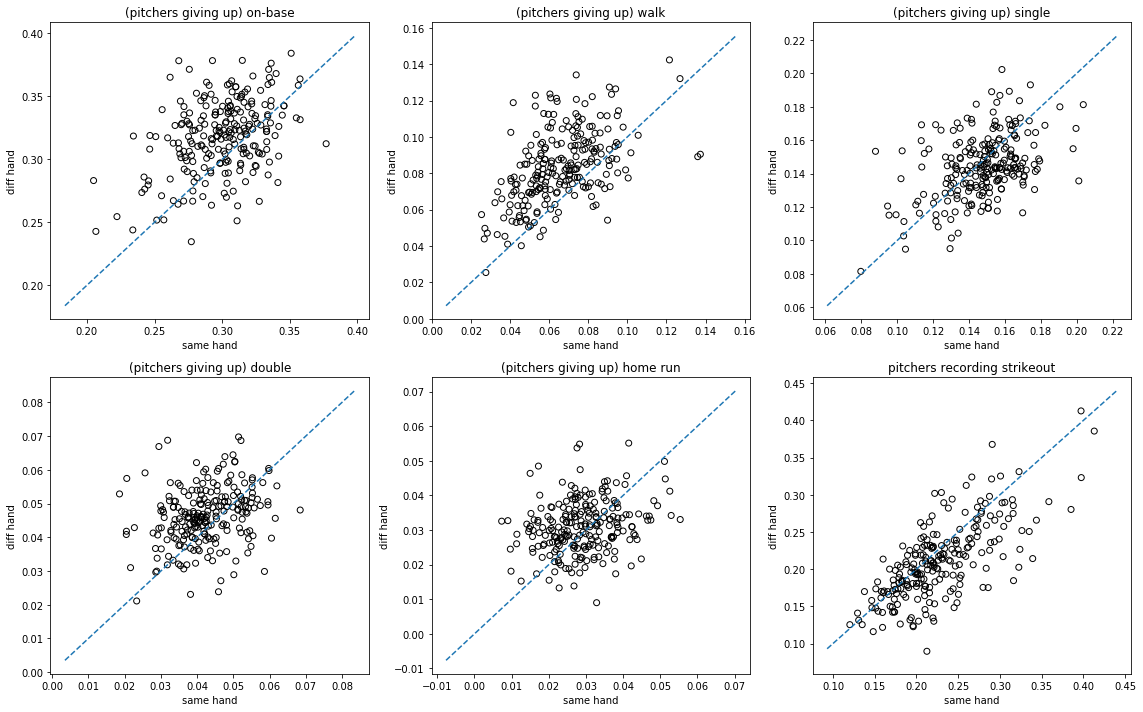

<IPython.core.display.Javascript object>

In [274]:
# Pitchers same vs. different handedness

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))

ax1.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("(pitchers giving up) on-base")
ax1.set_xlabel("same hand")
ax1.set_ylabel("diff hand")
abline(1, 0, ax1)

ax2.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("(pitchers giving up) walk")
ax2.set_xlabel("same hand")
ax2.set_ylabel("diff hand")
abline(1, 0, ax2)

ax3.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax3.set_title("(pitchers giving up) single")
ax3.set_xlabel("same hand")
ax3.set_ylabel("diff hand")
abline(1, 0, ax3)

ax4.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax4.set_title("(pitchers giving up) double")
ax4.set_xlabel("same hand")
ax4.set_ylabel("diff hand")
abline(1, 0, ax4)

ax5.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax5.set_title("(pitchers giving up) home run")
ax5.set_xlabel("same hand")
ax5.set_ylabel("diff hand")
abline(1, 0, ax5)

ax6.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax6.set_title("pitchers recording strikeout")
ax6.set_xlabel("same hand")
ax6.set_ylabel("diff hand")
abline(1, 0, ax6)

plt.tight_layout()

# Setting the dataframe for the model

In [86]:
col4model_preprocess = [
    "batter",
    "pitcher",
    "events",
    "stand",
    "p_throws",
    "inning_topbot",
    "onbase_event",
    "walk_event",
    "single_event",
    "double_event",
    "triple_event",
    "homerun_event",
    "strikeout_event",
]

df_sc_all_preprocess = df_sc_all.loc[:, col4model_preprocess].copy()

<IPython.core.display.Javascript object>

In [87]:
# Make feature to represent bp handedness
df_sc_all_preprocess["bp_hand_samediff"] = 0
bool_bp_hand_samediff = (
    df_sc_all_preprocess["stand"] != df_sc_all_preprocess["p_throws"]
)
df_sc_all_preprocess.loc[bool_bp_hand_samediff, "bp_hand_samediff"] = 1

# Make feature to represent home/away, top/bottom
df_sc_all_preprocess["inning_topbot"].replace({"Top": 0, "Bot": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [88]:
df_sc_all_preprocess.head()

,batter,pitcher,events,stand,p_throws,inning_topbot,onbase_event,walk_event,single_event,double_event,triple_event,homerun_event,strikeout_event,bp_hand_samediff
0,150029.0,544727.0,field_out,R,R,0,0,0,0,0,0,0,0,0
1,547180.0,544727.0,double,L,R,0,1,0,0,1,0,0,0,1
2,607208.0,544727.0,strikeout,R,R,0,0,0,0,0,0,0,1,0
3,543685.0,544727.0,field_out,R,R,0,0,0,0,0,0,0,0,0
4,502517.0,595014.0,grounded_into_double_play,L,R,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [89]:
df_sc_all_preprocess_wbat = pd.merge(
    df_sc_all_preprocess,
    df_batting_fromsc_250pa_prop_events,
    left_on="batter",
    right_index=True,
)

<IPython.core.display.Javascript object>

In [90]:
df_sc_all_preprocess_wbat.head()

,batter,pitcher,events,stand,p_throws,inning_topbot,onbase_event,walk_event,single_event,double_event,...,prop_triple_event_p_throws_same,prop_homerun_event_p_throws_same,prop_strikeout_event_p_throws_same,prop_onbase_event_p_throws_diff,prop_walk_event_p_throws_diff,prop_single_event_p_throws_diff,prop_double_event_p_throws_diff,prop_triple_event_p_throws_diff,prop_homerun_event_p_throws_diff,prop_strikeout_event_p_throws_diff
0,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
17,150029.0,477003.0,field_out,R,L,0,0,0,0,0,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
37,150029.0,594798.0,strikeout,R,R,0,0,0,0,0,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
53,150029.0,594798.0,strikeout,R,R,0,0,0,0,0,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714
2224,150029.0,592665.0,strikeout,R,R,0,0,0,0,0,...,0.00201207,0.027163,0.231388,0.357143,0.114286,0.110714,0.0714286,0,0.0571429,0.210714


<IPython.core.display.Javascript object>

In [91]:
df_sc_all_preprocess_wbat_wpitch = pd.merge(
    df_sc_all_preprocess_wbat,
    df_pitching_fromsc_500pa_prop_events,
    left_on="pitcher",
    right_index=True,
)

<IPython.core.display.Javascript object>

In [92]:
df_sc_all_preprocess_wbat_wpitch.shape

(324806, 96)

<IPython.core.display.Javascript object>

In [93]:
df_sc_all_preprocess_wbat_wpitch.head()

,batter,pitcher,events,stand,p_throws,inning_topbot,onbase_event,walk_event,single_event,double_event,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
0,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
27772,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
28866,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
155920,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
158235,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424


<IPython.core.display.Javascript object>

In [94]:
preprocess_col = [
    "onbase_event",
    "bp_hand_samediff",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
    "inning_topbot",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()

<IPython.core.display.Javascript object>

In [95]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

,onbase_event,bp_hand_samediff,prop_onbase_event_overall_x,prop_onbase_event_overall_y,inning_topbot
0,0,0,0.321036,0.300919,0
27772,1,0,0.321036,0.300919,1
28866,1,0,0.321036,0.300919,1
155920,0,0,0.321036,0.300919,0
158235,0,0,0.321036,0.300919,0


<IPython.core.display.Javascript object>

In [96]:
# Selection of same, diff handedness columns for historical proportion event

# Initiate columns
prop_col = ["prop_onbase_event_p_throws_handcomp", "prop_onbase_event_stand_handcomp"]
same_prop_col = ["prop_onbase_event_p_throws_same", "prop_onbase_event_stand_same"]
diff_prop_col = ["prop_onbase_event_p_throws_diff", "prop_onbase_event_stand_diff"]

df_sc_all_preprocess_wbat_wpitch_4model[prop_col[0]] = None
df_sc_all_preprocess_wbat_wpitch_4model[prop_col[1]] = None

bool_atbats_sameh = df_sc_all_preprocess_wbat_wpitch["bp_hand_samediff"] == 0
bool_atbats_diffh = df_sc_all_preprocess_wbat_wpitch["bp_hand_samediff"] == 1

# Add values depending on handedness matchup
df_sc_all_preprocess_wbat_wpitch_4model.loc[
    bool_atbats_sameh, prop_col
] = df_sc_all_preprocess_wbat_wpitch.loc[bool_atbats_sameh, same_prop_col].rename(
    columns=dict(zip(same_prop_col, prop_col))
)

df_sc_all_preprocess_wbat_wpitch_4model.loc[
    bool_atbats_diffh, prop_col
] = df_sc_all_preprocess_wbat_wpitch.loc[bool_atbats_diffh, diff_prop_col].rename(
    columns=dict(zip(diff_prop_col, prop_col))
)

<IPython.core.display.Javascript object>

In [97]:
feature_col_now = [
    "bp_hand_samediff",
    "inning_topbot",
]

feature_col = feature_col_now + prop_col
target_col = "onbase_event"

X_ob = df_sc_all_preprocess_wbat_wpitch_4model[feature_col].copy()
y_ob = df_sc_all_preprocess_wbat_wpitch_4model[target_col].copy()


<IPython.core.display.Javascript object>

# Run logistic regression

## Split data

In [127]:
def get_split_data(X, y, testsize):

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    from sklearn import preprocessing

    # Scale features based on training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scale = scaler.transform(X_train)

    # Apply transformation to test data
    X_test_scale = scaler.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test, scaler

<IPython.core.display.Javascript object>

In [110]:
X_ob_scale_train, X_ob_scale_test, y_ob_train, y_ob_test, scale_ob = get_split_data(
    X_ob, y_ob, 0.3
)

<IPython.core.display.Javascript object>

In [633]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [634]:
log_reg_ob, df_eval_ob = run_logreg_model(
    X_ob_scale_train, y_ob_train, X_ob_scale_test, y_ob_test
)

<IPython.core.display.Javascript object>

In [635]:
df_eval_ob.head()

,test,pred,predprob
390736,0,0,0.348375
416641,1,0,0.484469
769534,0,0,0.490117
389495,1,1,0.537113
918789,0,1,0.593330


<IPython.core.display.Javascript object>

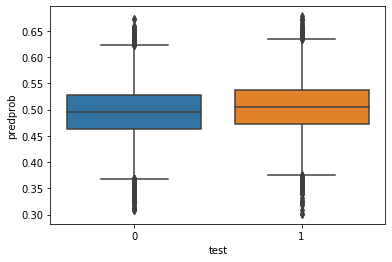

<IPython.core.display.Javascript object>

In [636]:
sns.boxplot(data=df_eval_ob, x="test", y="predprob")

In [637]:
print(metrics.classification_report(df_eval_ob["test"], df_eval_ob["pred"]))

              precision    recall  f1-score   support

           0       0.71      0.54      0.61     66185
           1       0.35      0.54      0.43     31257

    accuracy                           0.54     97442
   macro avg       0.53      0.54      0.52     97442
weighted avg       0.60      0.54      0.55     97442



<IPython.core.display.Javascript object>

# Run random forest

In [433]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>

In [434]:
def run_randomforest_v0(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators=1000, random_state=19)
    rf.fit(X_train_scale_set, y_train_set)

    y_pred = rf.predict(X_test_scale_set)
    y_predprob = rf.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [435]:
log_reg_ob_rf, df_eval_ob_rf = run_randomforest_v0(
    X_ob_scale_train, y_ob_train, X_ob_scale_test, y_ob_test
)

<IPython.core.display.Javascript object>

In [436]:
print(metrics.classification_report(df_eval_ob_rf["test"], df_eval_ob_rf["pred"]))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74     88366
           1       0.33      0.21      0.26     41557

    accuracy                           0.61    129923
   macro avg       0.51      0.51      0.50    129923
weighted avg       0.57      0.61      0.58    129923



<IPython.core.display.Javascript object>

**Model considerations**


Notes from Fiona
<br>
https://www.analyticsvidhya.com/blog/2018/10/interpret-random-forest-model-machine-learning-programmers/
if you have time I recommend watching his lectures (the first 4 or so are on random forest), it'll help you be able to use it to understand your features. All of his lectures are also online and written up as an article too

this was the article that very crudely tested 4 classification models
logistic regression, random forest, SVC and NB
I tried it more to get a directional idea of which could be worth spending more time on
avatar
this one also has other models like KNN (https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/), but I didn't find them useful.

https://evgenypogorelov.com/multiclass-xgb-shap.html
and here's XGBoost


# Regression approaches, using historical proportions

## Using overall percentages

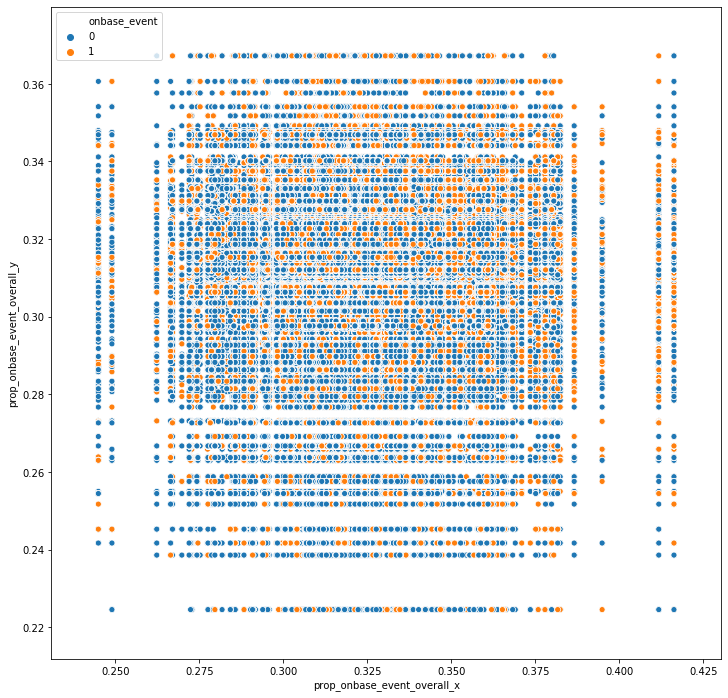

<IPython.core.display.Javascript object>

In [113]:
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))
f, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=df_sc_all_preprocess_wbat_wpitch,
    x="prop_onbase_event_overall_x",
    y="prop_onbase_event_overall_y",
    hue="onbase_event",
    ax=ax1,
)

# sns.scatterplot(
#     data=df_sc_all_preprocess_wbat_wpitch,
#     x="prop_onbase_event_p_throws_same",
#     y="prop_onbase_event_stand_same",
#     hue="onbase_event",
#     ax=ax2,
# )

# sns.scatterplot(
#     data=df_sc_all_preprocess_wbat_wpitch,
#     x="prop_onbase_event_p_throws_diff",
#     y="prop_onbase_event_stand_diff",
#     hue="onbase_event",
#     ax=ax3,
# )

In [114]:
df_sc_all_preprocess_wbat_wpitch.shape

(324806, 96)

<IPython.core.display.Javascript object>

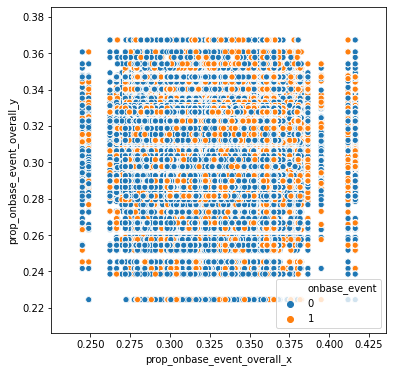

<IPython.core.display.Javascript object>

In [115]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

df_temp = df_sc_all_preprocess_wbat_wpitch.copy()

sns.scatterplot(
    data=df_temp,
    x="prop_onbase_event_overall_x",
    y="prop_onbase_event_overall_y",
    hue="onbase_event",
    ax=ax1,
);


In [131]:
bool_x_vals = df_sc_all_preprocess_wbat_wpitch["prop_onbase_event_overall_x"].between(
    0.275, 0.375
)
bool_y_vals = df_sc_all_preprocess_wbat_wpitch["prop_onbase_event_overall_y"].between(
    0.24, 0.36
)

df_temp_focus = df_sc_all_preprocess_wbat_wpitch.loc[(bool_x_vals & bool_y_vals), :]

<IPython.core.display.Javascript object>

## KNN

In [116]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

<IPython.core.display.Javascript object>

In [18]:
feature_col = ["prop_onbase_event_overall_x", "prop_onbase_event_overall_y"]

<IPython.core.display.Javascript object>

In [19]:
X_knn = df_temp[feature_col].copy()
y_knn = df_temp[target_col].copy()


NameError: name 'df_temp' is not defined

<IPython.core.display.Javascript object>

In [ ]:
(
    X_knn_scale_train,
    X_knn_scale_test,
    y_knn_train,
    y_knn_test,
    scale_knn,
) = get_split_data(X_knn, y_knn, 0.3)

In [703]:
rmse_val = []  # to store rmse values for different k
for K in range(100):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model.fit(X_knn_scale_train, y_knn_train)  # fit the model
    pred = model.predict(X_knn_scale_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_knn_test, pred))  # calculate rmse
    df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred})
    rmse_val.append(error)  # store rmse values
    # print("RMSE value for k= ", K, "is:", error)

<IPython.core.display.Javascript object>

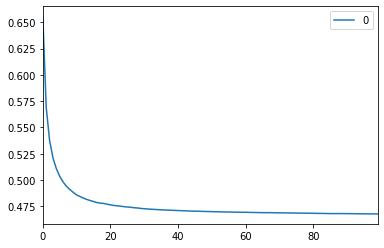

<IPython.core.display.Javascript object>

In [704]:
# plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()

In [713]:
df_eval.shape

(97442, 2)

<IPython.core.display.Javascript object>

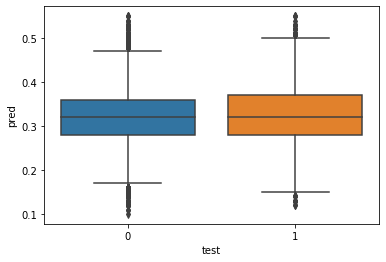

<IPython.core.display.Javascript object>

In [706]:
sns.boxplot(data=df_eval, x="test", y="pred")

In [707]:
pred_train = model.predict(X_knn_scale_train)

<IPython.core.display.Javascript object>

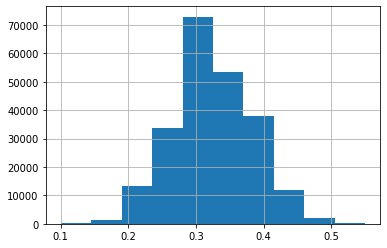

<IPython.core.display.Javascript object>

In [708]:
pd.Series(pred_train).hist()

In [709]:
# Make heatmap spreadsheet

bat_cat_min, bat_cat_max = 0.15, 0.5
pitch_cat_min, pitch_cat_max = 0.8, 1.8
n_points = 20

df_vals4heatmap = pd.DataFrame(
    {
        "batter_cat": sorted(
            np.linspace(bat_cat_min, bat_cat_max, n_points).tolist() * n_points
        ),
        "pitcher_cat": (
            np.linspace(pitch_cat_min, pitch_cat_max, n_points).tolist() * n_points
        ),
    }
)

# Scale values
df_vals4heatmap_scale = scale_knn.transform(df_vals4heatmap)

# Use model to make predictions
y_pred_vals4heatmap = model.predict(df_vals4heatmap_scale)

df_vals4heatmap["pred"] = y_pred_vals4heatmap

<IPython.core.display.Javascript object>

In [697]:
def make_heatmap(vals_heatmap):
    vals4heatmap_pivot = vals_heatmap.pivot("batter_cat", "pitcher_cat", "pred")

    def fmt(s):
        try:
            n = "{:.3f}".format(float(s))
        except:
            n = ""
        return n

    f, ax1 = plt.subplots(figsize=(8, 8))
    ax1 = sns.heatmap(vals4heatmap_pivot, cmap="RdBu_r")  # , annot=True)
    ax1.set_xticklabels([fmt(label.get_text()) for label in ax1.get_xticklabels()])
    ax1.invert_yaxis()
    ax1.set_yticklabels([fmt(label.get_text()) for label in ax1.get_yticklabels()])

    #     batter_obp = np.float(
    #         df_batting_100pa.loc[df_batting_100pa["Name"] == batter_name, "OBP"]
    #     )

    #     pitcher_whip = np.float(
    #         df_pitching_50ip.loc[df_pitching_50ip["Name"] == pitcher_name, "WHIP"]
    #     )

    #     bat_val, pitch_val = batter_obp, pitcher_whip
    #     x_on_plot = (pitch_val / pitch_cat_max) * n_points
    #     y_on_plot = (bat_val / bat_cat_max) * n_points
    # ax1.scatter(x_on_plot, y_on_plot, marker="*", s=100, color="orange")

    #     save_name = (
    #         "heatmap_"
    #         + (batter_name).replace(" ", "-")
    #         + "_"
    #         + (pitcher_name).replace(" ", "-")
    #     )

    #     dir_path = "./flask_insight_notes/flask_baseball/flaskexample/static/bp_hist/"
    #     plt.savefig(dir_path + save_name)

    # return save_name + ".png"
    return None

<IPython.core.display.Javascript object>

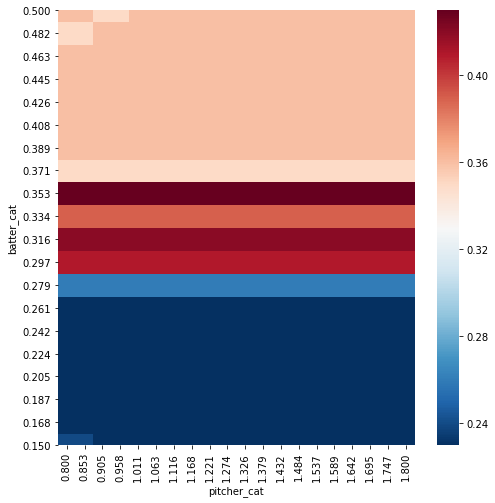

<IPython.core.display.Javascript object>

In [710]:
make_heatmap(df_vals4heatmap)

### Using GridSearch

## Radius Nearest Neighbors

In [117]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [151]:
def get_split_data_noscale(X, y, testsize):

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [4]:
df_temp = df_sc_all_preprocess_wbat_wpitch.iloc[0:50000, :].copy()
feature_col = ["prop_onbase_event_overall_x", "prop_onbase_event_overall_y"]

NameError: name 'df_sc_all_preprocess_wbat_wpitch' is not defined

In [3]:
df_temp.shape

NameError: name 'df_temp' is not defined

In [153]:
X_knn = df_temp_focus[feature_col].copy()
y_knn = df_temp_focus[target_col].copy()

<IPython.core.display.Javascript object>

In [154]:
(
    X_knn_noscale_train,
    X_knn_noscale_test,
    y_knn_train,
    y_knn_test,
) = get_split_data_noscale(X_knn, y_knn, 0.3)

<IPython.core.display.Javascript object>

In [ ]:

# neigh = RadiusNeighborsClassifier(radius=1.0)
# neigh.fit(X_ob_scale_train, y_ob_train)
# RadiusNeighborsClassifier(...)

In [ ]:
rmse_val = []  # to store rmse values for different r
for r in [0.5, 1, 10, 20]:
    # r = r + 1
    neigh = RadiusNeighborsClassifier(radius=r)
    neigh.fit(X_knn_noscale_train, y_knn_train)
    pred = neigh.predict(X_knn_noscale_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_knn_test, pred))  # calculate rmse
    df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred})
    rmse_val.append(error)  # store rmse values
    print("RMSE value for r= ", r, "is:", error)

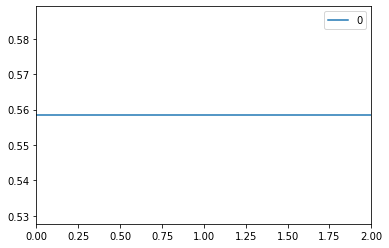

<IPython.core.display.Javascript object>

In [122]:
# plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()

In [137]:
df_eval["pred"].sum()

0

<IPython.core.display.Javascript object>

In [138]:
predprob = neigh.predict_proba(X_knn_scale_test)

<IPython.core.display.Javascript object>

In [140]:
df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred, "predprob": predprob[:, 1]})

<IPython.core.display.Javascript object>

In [141]:
df_eval.head()

,test,pred,predprob
836439,1,0,0.319629
919851,0,0,0.319629
284537,1,0,0.319629
852696,0,0,0.319629
458629,0,0,0.319629


<IPython.core.display.Javascript object>

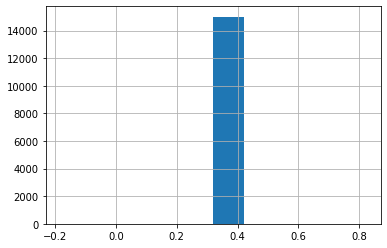

<IPython.core.display.Javascript object>

In [142]:
df_eval["predprob"].hist()

### Using GridSearch

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# Linear regression with target construction

In [98]:
df_sc_all_preprocess_wbat_wpitch.head()

,batter,pitcher,events,stand,p_throws,inning_topbot,onbase_event,walk_event,single_event,double_event,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
0,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
27772,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
28866,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
155920,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
158235,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424


<IPython.core.display.Javascript object>

## Using overall on-base percentage

In [99]:
preprocess_col = [
    "onbase_event",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()

<IPython.core.display.Javascript object>

In [100]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

,onbase_event,prop_onbase_event_overall_x,prop_onbase_event_overall_y
0,0,0.321036,0.300919
27772,1,0.321036,0.300919
28866,1,0.321036,0.300919
155920,0,0.321036,0.300919
158235,0,0.321036,0.300919


<IPython.core.display.Javascript object>

## Target construction via binning

In [112]:
# Bin these so that the most frequent categories are subdivided more
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_x"], 50
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_y"], 50
)

<IPython.core.display.Javascript object>

In [113]:
df_sc_all_preprocess_wbat_wpitch_4model.shape

(324806, 5)

<IPython.core.display.Javascript object>

In [114]:
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"].unique()

[(0.32, 0.3214], (0.3785, 0.3824], (0.3427, 0.3459], (0.3683, 0.3751], (0.341, 0.3427], ..., (0.3129, 0.3142], (0.3824, 0.4163], (0.3078, 0.3085], (0.3638, 0.3683], (0.3214, 0.3227]]
Length: 50
Categories (50, interval[float64]): [(0.2449, 0.2744] < (0.2744, 0.2788] < (0.2788, 0.285] < (0.285, 0.2883] ... (0.3683, 0.3751] < (0.3751, 0.3785] < (0.3785, 0.3824] < (0.3824, 0.4163]]

<IPython.core.display.Javascript object>

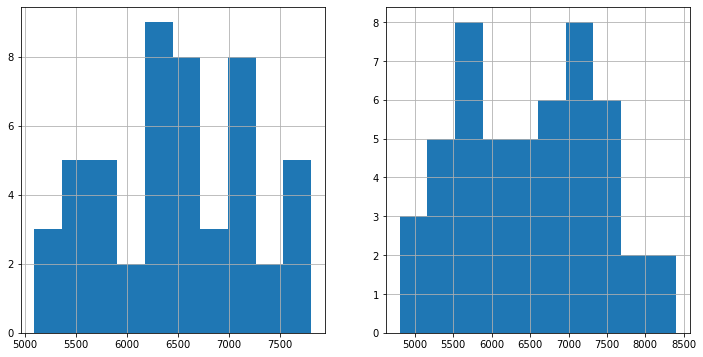

<IPython.core.display.Javascript object>

In [115]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"].value_counts().hist(
    ax=ax1
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"].value_counts().hist(
    ax=ax2
)

In [176]:
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"].value_counts().mean()

6496.12

<IPython.core.display.Javascript object>

In [119]:
def get_df_binned_4model(df_sc_4model, bat_cat, pitch_cat, target):
    # Get the proportion from each category combination with groupby
    df_sc_4model_agg = df_sc_4model.groupby([bat_cat, pitch_cat])[target].mean()

    bat_cat_mp = pd.Series(df_sc_4model_agg.index.get_level_values(0).tolist()).apply(
        lambda x: x.mid
    )

    pitch_cat_mp = pd.Series(df_sc_4model_agg.index.get_level_values(1).tolist()).apply(
        lambda x: x.mid
    )

    df_sc_4model_agg_final = pd.DataFrame(
        {
            "event_mean": df_sc_4model_agg.tolist(),
            "batter_cat": bat_cat_mp,
            "pitcher_cat": pitch_cat_mp,
        }
    )

    return df_sc_4model_agg_final

<IPython.core.display.Javascript object>

In [120]:
df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
    df_sc_all_preprocess_wbat_wpitch_4model,
    "prop_onbase_batter",
    "prop_onbase_pitcher",
    "onbase_event",
)

<IPython.core.display.Javascript object>

In [122]:
print(df_sc_all_preprocess_wbat_wpitch_4model_agg.shape)
df_sc_all_preprocess_wbat_wpitch_4model_agg.head()

(2500, 3)


,event_mean,batter_cat,pitcher_cat
0,0.174107,0.25965,0.23805
1,0.235294,0.25965,0.25735
2,0.230000,0.25965,0.26445
3,0.202454,0.25965,0.26945
4,0.239496,0.25965,0.27685


<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion of at-bats getting on-base')

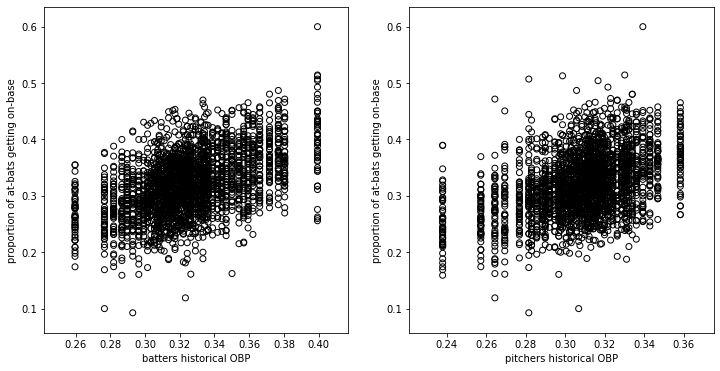

<IPython.core.display.Javascript object>

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["batter_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("proportion of at-bats getting on-base")

ax2.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["pitcher_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_xlabel("pitchers historical OBP")
ax2.set_ylabel("proportion of at-bats getting on-base")

### Run LM model

In [125]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

<IPython.core.display.Javascript object>

**See above for split model function**

In [134]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [135]:
def run_linreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scale_set, y_train_set)

    y_pred = lin_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lin_reg, df_eval

<IPython.core.display.Javascript object>

In [136]:
lin_reg_v0, df_eval_v0 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [137]:
df_eval_v0.head()

,test,pred
2201,0.231579,0.303162
2248,0.355030,0.394680
926,0.369863,0.316312
534,0.241667,0.313641
529,0.301724,0.309753


<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

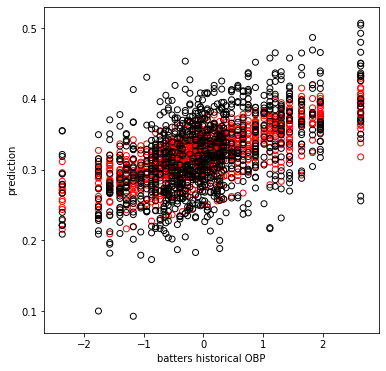

<IPython.core.display.Javascript object>

In [146]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v0["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v0["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [138]:
metrics.r2_score(df_eval_v0["test"], df_eval_v0["pred"])

0.4502250876079835

<IPython.core.display.Javascript object>

## Natural log transformation


In [157]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = np.log(df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy())
y_ob_oa = np.log(df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy())


<IPython.core.display.Javascript object>

In [155]:
X_ob_oa.head()

,batter_cat,pitcher_cat
0,-1.348421,-1.435275
1,-1.348421,-1.357318
2,-1.348421,-1.330103
3,-1.348421,-1.311372
4,-1.348421,-1.284279


<IPython.core.display.Javascript object>

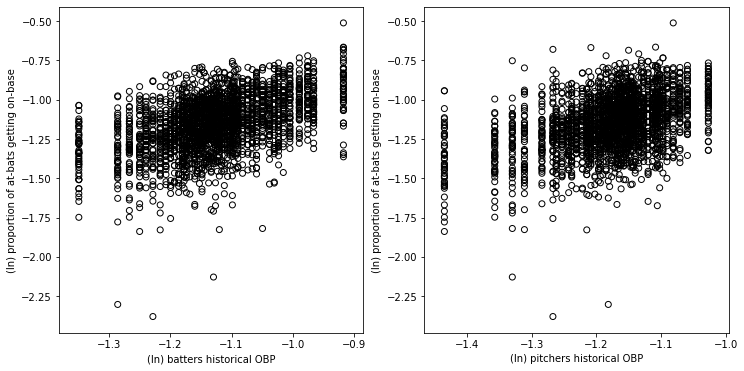

<IPython.core.display.Javascript object>

In [158]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    X_ob_oa.iloc[:, 0], y_ob_oa, facecolors="none", edgecolors="black",
)
ax1.set_xlabel("(ln) batters historical OBP")
ax1.set_ylabel("(ln) proportion of at-bats getting on-base")

ax2.scatter(
    X_ob_oa.iloc[:, 1], y_ob_oa, facecolors="none", edgecolors="black",
)
ax2.set_xlabel("(ln) pitchers historical OBP")
ax2.set_ylabel("(ln) proportion of at-bats getting on-base")

### Run LM model after log transformation

In [159]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [160]:
lin_reg_v1, df_eval_v1 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [161]:
df_eval_v1.head()

,test,pred
2201,-1.462834,-1.224979
2248,-1.035554,-0.925693
926,-0.994623,-1.160302
534,-1.420196,-1.170227
529,-1.198242,-1.182252


<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

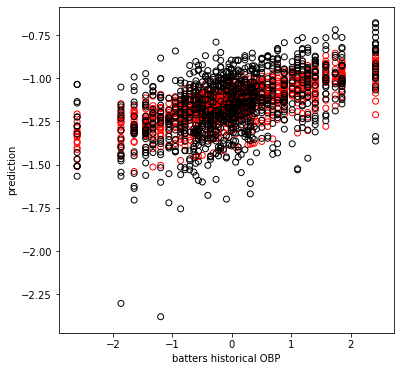

<IPython.core.display.Javascript object>

In [162]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v1["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v1["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [164]:
metrics.r2_score(df_eval_v1["test"], df_eval_v1["pred"])

0.4296785018388639

<IPython.core.display.Javascript object>

## Using handedness information

In [214]:
df_sc_all_preprocess_wbat_wpitch.head()

,batter,pitcher,events,stand,p_throws,inning_topbot,onbase_event,walk_event,single_event,double_event,...,prop_triple_event_stand_same,prop_homerun_event_stand_same,prop_strikeout_event_stand_same,prop_onbase_event_stand_diff,prop_walk_event_stand_diff,prop_single_event_stand_diff,prop_double_event_stand_diff,prop_triple_event_stand_diff,prop_homerun_event_stand_diff,prop_strikeout_event_stand_diff
0,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
27772,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
28866,150029.0,544727.0,single,R,R,1,1,0,1,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
155920,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424
158235,150029.0,544727.0,field_out,R,R,0,0,0,0,0,...,0.00139665,0.0125698,0.287709,0.318644,0.0932203,0.154237,0.0474576,0.00338983,0.0152542,0.225424


<IPython.core.display.Javascript object>

In [264]:
def make_handedness_specific_df(df, df_4model, event_type):
    # Selection of same, diff handedness columns for historical proportion event

    # Initiate columns
    prop_col = [
        "prop_" + event_type + "_event_p_throws_handcomp",
        "prop_" + event_type + "_event_stand_handcomp",
    ]
    same_prop_col = [
        "prop_" + event_type + "_event_p_throws_same",
        "prop_" + event_type + "_event_stand_same",
    ]
    diff_prop_col = [
        "prop_" + event_type + "_event_p_throws_diff",
        "prop_" + event_type + "_event_stand_diff",
    ]

    df_4model[prop_col[0]] = None
    df_4model[prop_col[1]] = None

    bool_atbats_sameh = df["bp_hand_samediff"] == 0
    bool_atbats_diffh = df["bp_hand_samediff"] == 1

    # Add values depending on handedness matchup
    df_4model.loc[bool_atbats_sameh, prop_col] = df.loc[
        bool_atbats_sameh, same_prop_col
    ].rename(columns=dict(zip(same_prop_col, prop_col)))

    df_4model.loc[bool_atbats_diffh, prop_col] = df.loc[
        bool_atbats_diffh, diff_prop_col
    ].rename(columns=dict(zip(diff_prop_col, prop_col)))

    return df_4model

<IPython.core.display.Javascript object>

In [ ]:
#df_sc_all_preprocess_wbat_wpitch_4model = make_handedness_specific_df(df_sc_all_preprocess_wbat_wpitch)

In [216]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

,onbase_event,prop_onbase_event_overall_x,prop_onbase_event_overall_y,prop_onbase_batter,prop_onbase_pitcher,prop_onbase_event_p_throws_handcomp,prop_onbase_event_stand_handcomp
0,0,0.321036,0.300919,"(0.3208, 0.3214]","(0.2988, 0.3009]",0.310865,0.286313
27772,1,0.321036,0.300919,"(0.3208, 0.3214]","(0.2988, 0.3009]",0.310865,0.286313
28866,1,0.321036,0.300919,"(0.3208, 0.3214]","(0.2988, 0.3009]",0.310865,0.286313
155920,0,0.321036,0.300919,"(0.3208, 0.3214]","(0.2988, 0.3009]",0.310865,0.286313
158235,0,0.321036,0.300919,"(0.3208, 0.3214]","(0.2988, 0.3009]",0.310865,0.286313


<IPython.core.display.Javascript object>

In [178]:
# Bin these so that the most frequent categories are subdivided more
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_p_throws_handcomp"], 50
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_stand_handcomp"], 50
)

<IPython.core.display.Javascript object>

In [180]:
df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
    df_sc_all_preprocess_wbat_wpitch_4model,
    "prop_onbase_batter",
    "prop_onbase_pitcher",
    "onbase_event",
)

<IPython.core.display.Javascript object>

In [181]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.head()

,event_mean,batter_cat,pitcher_cat
0,0.161435,0.2475,0.2235
1,0.216931,0.2475,0.2475
2,0.259459,0.2475,0.2570
3,0.204082,0.2475,0.2645
4,0.250000,0.2475,0.2685


<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion of at-bats getting on-base')

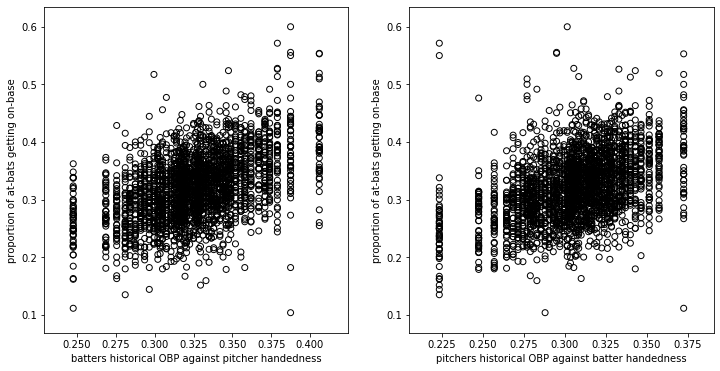

<IPython.core.display.Javascript object>

In [182]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["batter_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_xlabel("batters historical OBP against pitcher handedness")
ax1.set_ylabel("proportion of at-bats getting on-base")

ax2.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["pitcher_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_xlabel("pitchers historical OBP against batter handedness")
ax2.set_ylabel("proportion of at-bats getting on-base")

### Run LM model

In [187]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.isnull().sum()

event_mean     6
batter_cat     0
pitcher_cat    0
dtype: int64

<IPython.core.display.Javascript object>

In [189]:
# Drop rows with missing value
df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)

<IPython.core.display.Javascript object>

In [190]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.shape

(2494, 3)

<IPython.core.display.Javascript object>

In [191]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()


<IPython.core.display.Javascript object>

In [192]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [193]:
lin_reg_v2, df_eval_v2 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [194]:
df_eval_v2.head()

,test,pred
540,0.223529,0.322786
1682,0.366197,0.343451
1545,0.333333,0.362055
590,0.393258,0.324128
854,0.253165,0.277632


<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

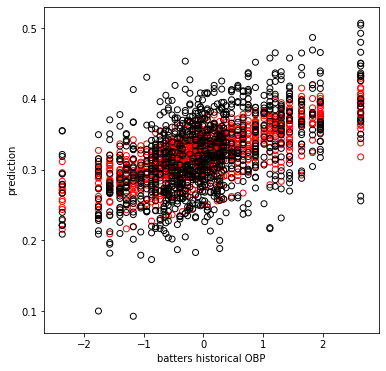

<IPython.core.display.Javascript object>

In [146]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v2["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v2["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [195]:
metrics.r2_score(df_eval_v2["test"], df_eval_v2["pred"])

0.43286029552329564

<IPython.core.display.Javascript object>

# Determining right number of qcuts

In [ ]:
preprocess_col = [
    "onbase_event",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()


No of cuts:  5
R2 score: 0.9936631794476001
No of cuts:  10
R2 score: 0.9196557678876578
No of cuts:  15
R2 score: 0.9175919219565578
No of cuts:  20
R2 score: 0.8342391892521545
No of cuts:  25
R2 score: 0.7695520076715783
No of cuts:  30
R2 score: 0.6848728701005476
No of cuts:  35
R2 score: 0.5934721751413012
No of cuts:  40
R2 score: 0.5417603405300049
No of cuts:  45
R2 score: 0.47596904031295983
No of cuts:  50
R2 score: 0.4502250876079835


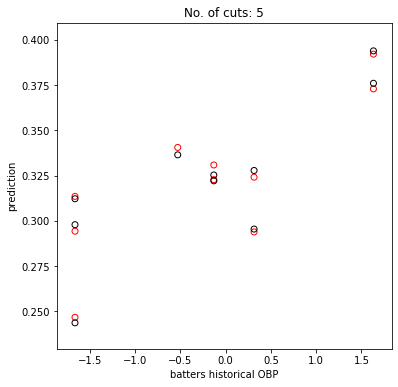

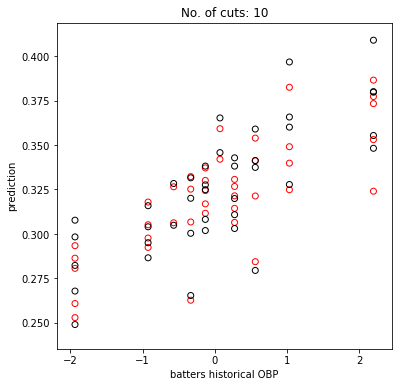

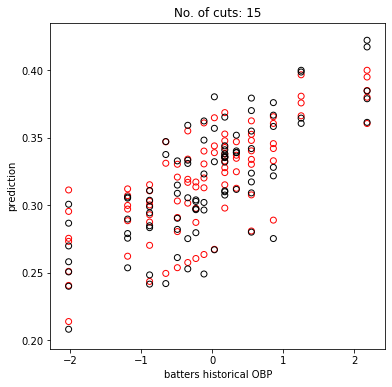

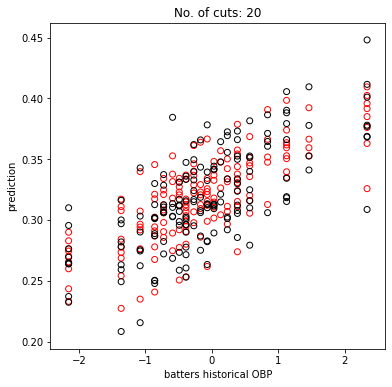

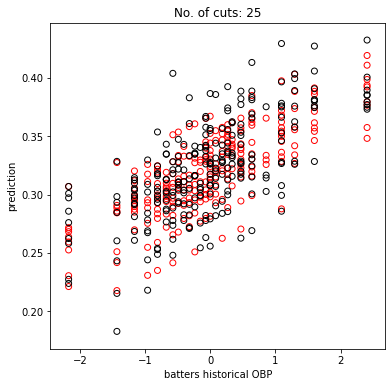

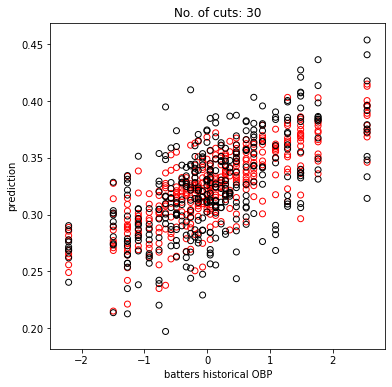

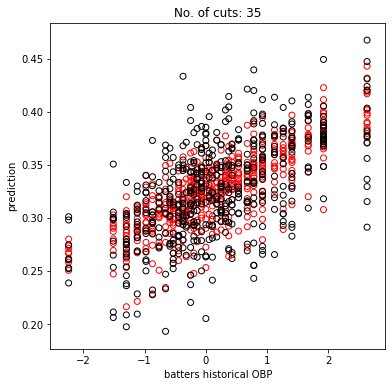

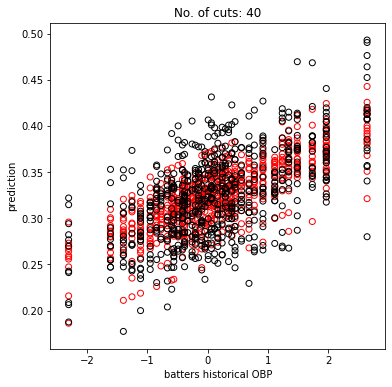

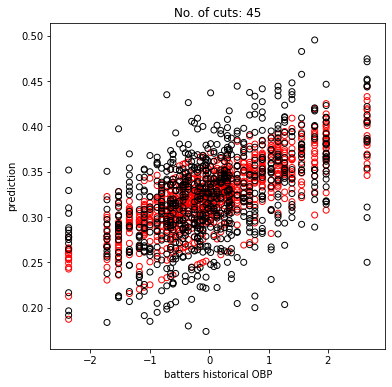

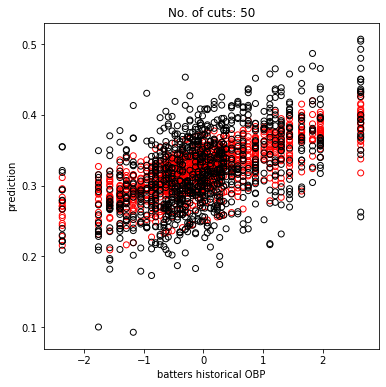

<IPython.core.display.Javascript object>

In [276]:
r2_list = list()
for no_cuts in range(5, 55, 5):
    print("No of cuts: ", no_cuts)

    # Bin these so that the most frequent categories are subdivided more
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_x"], no_cuts
    )
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_y"], no_cuts
    )

    no_avg_batters = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"]
        .value_counts()
        .mean()
    )
    no_avg_pitchers = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"]
        .value_counts()
        .mean()
    )

    #     print(
    #         "Avg. of batters and pitchers, respectively: ", no_avg_batters, no_avg_pitchers
    #     )

    #     print(
    #         "Avg. of batter/pitcher intersection bin: ",
    #         no_avg_batters / no_cuts,
    #         no_avg_pitchers / no_cuts,
    #     )

    df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
        df_sc_all_preprocess_wbat_wpitch_4model,
        "prop_onbase_batter",
        "prop_onbase_pitcher",
        "onbase_event",
    )

    # Remove rows with null values
    df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)
    #     print(
    #         "Shape of aggregated dataframe after removing null: ",
    #         df_sc_all_preprocess_wbat_wpitch_4model_agg.shape,
    #     )

    feature_col_now = [
        "batter_cat",
        "pitcher_cat",
    ]

    feature_col = feature_col_now
    target_col = "event_mean"

    X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
    y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

    (
        X_ob_oa_scale_train,
        X_ob_oa_scale_test,
        y_ob_oa_train,
        y_ob_oa_test,
        scale_ob,
    ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

    lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
        X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
    )

    print(
        colored(
            "R2 score: "
            + str(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])),
            "red",
        )
    )

    r2_list.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

    f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
    ax1.scatter(
        X_ob_oa_scale_test[:, 0],
        df_eval_vCheck["pred"],
        facecolors="none",
        edgecolors="red",
    )

    ax1.scatter(
        X_ob_oa_scale_test[:, 0],
        df_eval_vCheck["test"],
        facecolors="none",
        edgecolors="black",
    )

    ax1.set_xlabel("batters historical OBP")
    ax1.set_ylabel("prediction")
    ax1.set_title("No. of cuts: " + str(no_cuts))

### Adding handedness



In [226]:
r2_list_h = list()

<IPython.core.display.Javascript object>

In [227]:
for no_cuts in range(5, 50, 5):
    print("No of cuts: ", no_cuts)

    preprocess_col = [
        "onbase_event",
        "prop_onbase_event_overall_x",
        "prop_onbase_event_overall_y",
    ]

    df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
        preprocess_col
    ].copy()

    df_sc_all_preprocess_wbat_wpitch_4model = make_handedness_specific_df(
        df_sc_all_preprocess_wbat_wpitch, df_sc_all_preprocess_wbat_wpitch_4model
    )

    # Bin these so that the most frequent categories are subdivided more
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_p_throws_handcomp"],
        no_cuts,
    )
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_stand_handcomp"],
        no_cuts,
    )

    no_avg_batters = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"]
        .value_counts()
        .mean()
    )
    no_avg_pitchers = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"]
        .value_counts()
        .mean()
    )

    print(
        "Avg. of batters and pitchers, respectively: ", no_avg_batters, no_avg_pitchers
    )

    print(
        "Avg. of batter/pitcher intersection bin: ",
        no_avg_batters / no_cuts,
        no_avg_pitchers / no_cuts,
    )

    df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
        df_sc_all_preprocess_wbat_wpitch_4model,
        "prop_onbase_batter",
        "prop_onbase_pitcher",
        "onbase_event",
    )

    # Remove rows with null values
    df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)
    print(
        "Shape of aggregated dataframe after removing null: ",
        df_sc_all_preprocess_wbat_wpitch_4model_agg.shape,
    )

    feature_col_now = [
        "batter_cat",
        "pitcher_cat",
    ]

    feature_col = feature_col_now
    target_col = "event_mean"

    X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
    y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

    (
        X_ob_oa_scale_train,
        X_ob_oa_scale_test,
        y_ob_oa_train,
        y_ob_oa_test,
        scale_ob,
    ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

    lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
        X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
    )

    print(
        colored(
            "R2 score: "
            + str(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])),
            "red",
        )
    )

    r2_list_h.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

#     f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
#     ax1.scatter(
#         X_ob_oa_scale_test[:, 0],
#         df_eval_vCheck["pred"],
#         facecolors="none",
#         edgecolors="red",
#     )

#     ax1.scatter(
#         X_ob_oa_scale_test[:, 0],
#         df_eval_vCheck["test"],
#         facecolors="none",
#         edgecolors="black",
#     )

#     ax1.set_xlabel("batters historical OBP")
#     ax1.set_ylabel("prediction")
#     ax1.set_title("No. of cuts: " + str(no_cuts))

No of cuts:  5
Avg. of batters and pitchers, respectively:  64961.2 64961.2
Avg. of batter/pitcher intersection bin:  12992.24 12992.24
Shape of aggregated dataframe after removing null:  (25, 3)
R2 score: 0.9832997680939355
No of cuts:  10
Avg. of batters and pitchers, respectively:  32480.6 32480.6
Avg. of batter/pitcher intersection bin:  3248.06 3248.06
Shape of aggregated dataframe after removing null:  (100, 3)
R2 score: 0.9312307039504928
No of cuts:  15
Avg. of batters and pitchers, respectively:  21653.733333333334 21653.733333333334
Avg. of batter/pitcher intersection bin:  1443.5822222222223 1443.5822222222223
Shape of aggregated dataframe after removing null:  (225, 3)
R2 score: 0.9251557910478312
No of cuts:  20
Avg. of batters and pitchers, respectively:  16240.3 16240.3
Avg. of batter/pitcher intersection bin:  812.015 812.015
Shape of aggregated dataframe after removing null:  (400, 3)
R2 score: 0.8284591241258483
No of cuts:  25
Avg. of batters and pitchers, respective

<IPython.core.display.Javascript object>

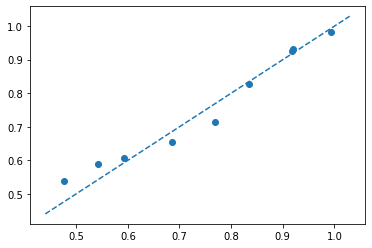

<IPython.core.display.Javascript object>

In [229]:
f, ax1 = plt.subplots()
ax1.scatter(r2_list, r2_list_h)
abline(1, 0, ax1)

In [231]:
df_r2_compare = pd.DataFrame(
    {"no_cuts": range(5, 50, 5), "no_hand": r2_list, "hand": r2_list_h}
)
df_r2_compare

,no_cuts,no_hand,hand
0,5,0.993663,0.983300
1,10,0.919656,0.931231
2,15,0.917592,0.925156
3,20,0.834239,0.828459
4,25,0.769552,0.715669
5,30,0.684873,0.654168
6,35,0.593472,0.605494
7,40,0.541760,0.589375
8,45,0.475969,0.539596


<IPython.core.display.Javascript object>

# All events

In [ ]:
df_sc_all_preprocess_wbat_wpitch

In [296]:
def get_no_cuts_check(event_type, df):

    preprocess_col = [
        event_type + "_event",
        "prop_" + event_type + "_event_overall_x",
        "prop_" + event_type + "_event_overall_y",
    ]

    df_4model = df[preprocess_col].copy()

    # Overall ---------

    cut_range = range(5, 55, 5)
    no_avg_b_p_list = list()
    no_bp_int_list = list()
    r2_list = list()
    r2_list_h = list()
    r2_list_htr = list()

    for no_cuts in cut_range:
        print("No of cuts: ", no_cuts)

        # Bin these so that the most frequent categories are subdivided more
        df_4model["prop_" + event_type + "_batter"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_overall_x"], no_cuts
        )
        df_4model["prop_" + event_type + "_pitcher"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_overall_y"], no_cuts
        )

        no_avg_batters = (
            df_4model["prop_" + event_type + "_batter"].value_counts().mean()
        )
        no_avg_pitchers = (
            df_4model["prop_" + event_type + "_pitcher"].value_counts().mean()
        )

        # no_avg_b_p_list.append((no_avg_batters, no_avg_pitchers))  # gives same value
        no_avg_b_p_list.append(no_avg_batters)

        # no_bp_int_list.append((no_avg_batters / no_cuts, no_avg_pitchers / no_cuts))  # gives same value
        no_bp_int_list.append(no_avg_batters / no_cuts)

        df_4model_agg = get_df_binned_4model(
            df_4model,
            "prop_" + event_type + "_batter",
            "prop_" + event_type + "_pitcher",
            "" + event_type + "_event",
        )

        # Remove rows with null values
        df_4model_agg.dropna(axis=0, inplace=True)

        feature_col_now = [
            "batter_cat",
            "pitcher_cat",
        ]

        feature_col = feature_col_now
        target_col = "event_mean"

        X_ob_oa = df_4model_agg[feature_col].copy()
        y_ob_oa = df_4model_agg[target_col].copy()

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
            X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
        )

        r2_list.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

        # Handedness ---------

        df_4model = make_handedness_specific_df(df, df_4model, event_type)

        # Bin these so that the most frequent categories are subdivided more
        df_4model["prop_" + event_type + "_batter"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_p_throws_handcomp"], no_cuts,
        )
        df_4model["prop_" + event_type + "_pitcher"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_stand_handcomp"], no_cuts,
        )

        no_avg_batters = (
            df_4model["prop_" + event_type + "_batter"].value_counts().mean()
        )
        no_avg_pitchers = (
            df_4model["prop_" + event_type + "_pitcher"].value_counts().mean()
        )

        df_4model_agg = get_df_binned_4model(
            df_4model,
            "prop_" + event_type + "_batter",
            "prop_" + event_type + "_pitcher",
            "" + event_type + "_event",
        )

        # Remove rows with null values
        df_4model_agg.dropna(axis=0, inplace=True)

        feature_col_now = [
            "batter_cat",
            "pitcher_cat",
        ]

        feature_col = feature_col_now
        target_col = "event_mean"

        X_ob_oa = df_4model_agg[feature_col].copy()
        y_ob_oa = df_4model_agg[target_col].copy()

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
            X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
        )

        r2_list_h.append(
            metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])
        )

        # Handedness with transformation
        X_ob_oa = np.log(df_4model_agg[feature_col].copy())
        y_ob_oa = np.log(df_4model_agg[target_col].copy())

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
            X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
        )

        try:
            r2_list_htr.append(
                metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])
            )
        except:
            r2_list_htr.append(None)

    # Summary
    df_eval_summary = pd.DataFrame()
    df_eval_summary["n_cuts"] = cut_range
    df_eval_summary["no_avg_b_p_list"] = no_avg_b_p_list
    df_eval_summary["no_bp_int_list"] = no_bp_int_list
    df_eval_summary["r2_list_o"] = r2_list
    df_eval_summary["r2_list_h"] = r2_list_h
    df_eval_summary["r2_diff_h_o"] = (
        df_eval_summary["r2_list_h"] - df_eval_summary["r2_list_o"]
    )
    df_eval_summary["r2_list_htr"] = r2_list_htr
    df_eval_summary["r2_diff_htr_h"] = (
        df_eval_summary["r2_list_htr"] - df_eval_summary["r2_list_h"]
    )

    return df_eval_summary

<IPython.core.display.Javascript object>

In [285]:
df_onbase_summary = get_no_cuts_check("onbase", df_sc_all_preprocess_wbat_wpitch)
df_onbase_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


,n_cuts,no_avg_b_p_list,no_bp_int_list,r2_list_o,r2_list_h,r2_diff_h_o,r2_list_htr,r2_diff_htr_h
0,5,64961.200000,12992.240000,0.993663,0.983300,-0.010363,0.974646,-0.008653
1,10,32480.600000,3248.060000,0.919656,0.931231,0.011575,0.928476,-0.002755
2,15,21653.733333,1443.582222,0.917592,0.925156,0.007564,0.922768,-0.002388
3,20,16240.300000,812.015000,0.834239,0.828459,-0.005780,0.834657,0.006197
4,25,12992.240000,519.689600,0.769552,0.715669,-0.053883,0.719587,0.003919
5,30,10826.866667,360.895556,0.684873,0.654168,-0.030705,0.667497,0.013329
6,35,9280.171429,265.147755,0.593472,0.605494,0.012022,0.603521,-0.001973
7,40,8120.150000,203.003750,0.541760,0.589375,0.047615,0.593280,0.003905
8,45,7217.911111,160.398025,0.475969,0.539596,0.063627,0.535867,-0.003729
9,50,6496.120000,129.922400,0.450225,0.432860,-0.017365,0.431297,-0.001563


<IPython.core.display.Javascript object>

In [ ]:
df_walk_summary = get_no_cuts_check("walk", df_sc_all_preprocess_wbat_wpitch)
df_walk_summary

In [291]:
y_ob_oa.isnull().sum()

0

<IPython.core.display.Javascript object>

In [292]:
df_single_summary = get_no_cuts_check("single", df_sc_all_preprocess_wbat_wpitch)
df_single_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>

In [271]:
df_double_summary = get_no_cuts_check("double", df_sc_all_preprocess_wbat_wpitch)
df_double_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


,n_cuts,no_avg_b_p_list,no_bp_int_list,r2_list,r2_list_h,r2_diff
0,5,64961.200000,12992.240000,0.943176,0.941578,-0.001597
1,10,32480.600000,3248.060000,0.827690,0.853202,0.025511
2,15,21653.733333,1443.582222,0.764789,0.824896,0.060107
3,20,16240.300000,812.015000,0.605948,0.687428,0.081480
4,25,12992.240000,519.689600,0.531359,0.620529,0.089170
5,30,10826.866667,360.895556,0.404133,0.503013,0.098880
6,35,9280.171429,265.147755,0.360601,0.444944,0.084343
7,40,8120.150000,203.003750,0.286895,0.329824,0.042929
8,45,7217.911111,160.398025,0.252241,0.320400,0.068160
9,50,6496.120000,129.922400,0.202389,0.260433,0.058044


<IPython.core.display.Javascript object>

In [272]:
df_homerun_summary = get_no_cuts_check("homerun", df_sc_all_preprocess_wbat_wpitch)
df_homerun_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


,n_cuts,no_avg_b_p_list,no_bp_int_list,r2_list,r2_list_h,r2_diff
0,5,64961.200000,12992.240000,0.934562,0.887175,-0.047387
1,10,32480.600000,3248.060000,0.946170,0.868201,-0.077969
2,15,21653.733333,1443.582222,0.906913,0.873731,-0.033182
3,20,16240.300000,812.015000,0.823173,0.862063,0.038891
4,25,12992.240000,519.689600,0.767260,0.747648,-0.019613
5,30,10826.866667,360.895556,0.663932,0.710508,0.046576
6,35,9280.171429,265.147755,0.661739,0.672958,0.011219
7,40,8120.150000,203.003750,0.582112,0.597324,0.015212
8,45,7217.911111,160.398025,0.550606,0.557542,0.006936
9,50,6496.120000,129.922400,0.466846,0.465398,-0.001448


<IPython.core.display.Javascript object>

In [293]:
df_strikeout_summary = get_no_cuts_check("strikeout", df_sc_all_preprocess_wbat_wpitch)
df_strikeout_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


,n_cuts,no_avg_b_p_list,no_bp_int_list,r2_list_o,r2_list_h,r2_diff_h_o,r2_list_htr,r2_diff_htr_h
0,5,64961.200000,12992.240000,0.934030,0.919835,-0.014195,0.983436,0.063602
1,10,32480.600000,3248.060000,0.941914,0.934396,-0.007517,0.963078,0.028681
2,15,21653.733333,1443.582222,0.951128,0.944998,-0.006130,0.975462,0.030464
3,20,16240.300000,812.015000,0.944455,0.925033,-0.019423,0.947364,0.022332
4,25,12992.240000,519.689600,0.918687,0.923029,0.004342,0.942675,0.019645
5,30,10826.866667,360.895556,0.880803,0.876840,-0.003963,0.897232,0.020393
6,35,9280.171429,265.147755,0.875955,0.864502,-0.011453,0.859386,-0.005116
7,40,8120.150000,203.003750,0.842757,0.840021,-0.002736,0.820665,-0.019356
8,45,7217.911111,160.398025,0.812635,0.810862,-0.001773,0.810829,-0.000033
9,50,6496.120000,129.922400,0.759085,0.770056,0.010970,0.739617,-0.030439


<IPython.core.display.Javascript object>

# Effect of feature transformation

In [ ]:
## Log transform 